In [28]:
from external_potential import Framework, PotentialType, ExternalPotential
import jax
import jax.numpy as jnp

<Axes: xlabel='X-axis', ylabel='Y-axis'>

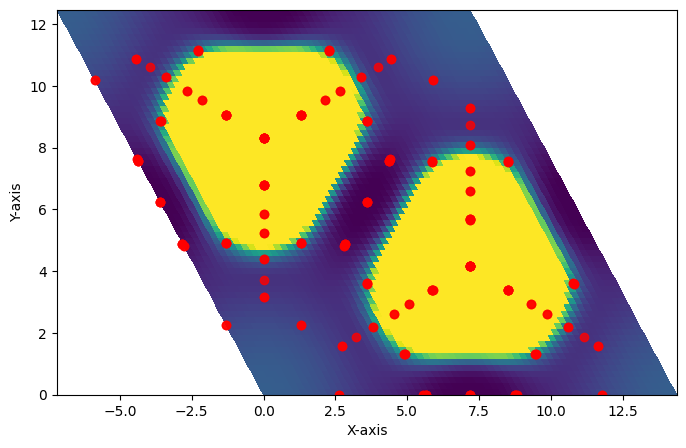

In [29]:
solid_parameters = {
    "O": { "sigma": 3.21, "epsilon_k": 76.3, "lambda_r": 12.0, "molarweight": 16.0 },
    "Si": { "sigma": 0.0, "epsilon_k": 0.0, "lambda_r": 12.0, "molarweight": 28.0 },
    #"Sa": { "sigma": 0.0, "epsilon_k": 0.0, "lambda_r": 12.0, "molarweight": 28.0 }
}

# PC-SAFT
fluid_parameters = {
    "methane": { "m": 1.0, "sigma": 3.70051, "epsilon_k": 150.07147 },
    #"ethane": { "m": 1.60689, "sigma": 3.51681, "epsilon_k": 191.45389 }
}

framework = Framework(cif="/Users/danielbock/PycharmProjects/MA/structures/MWW.cif")

external_potential = framework.calculate_external_potential(
    ngrid=(64,)*3, 
    interaction_potential_type=PotentialType.LennardJones, 
    cutoff_radius=12.0, 
    fluid_parameters=fluid_parameters, 
    solid_parameters=solid_parameters, 
    #binary_interaction_parameters=binary, 
    tail_correction_type='RASPA', 
    #block_files=['block1.res', 'block2.res'],
)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
framework.visualize_external_potential(ax, external_potential.reduced_potential(temperature=298, maximum_reduced_energy=10.0), fluid_index=1, show_contour_lines=False)


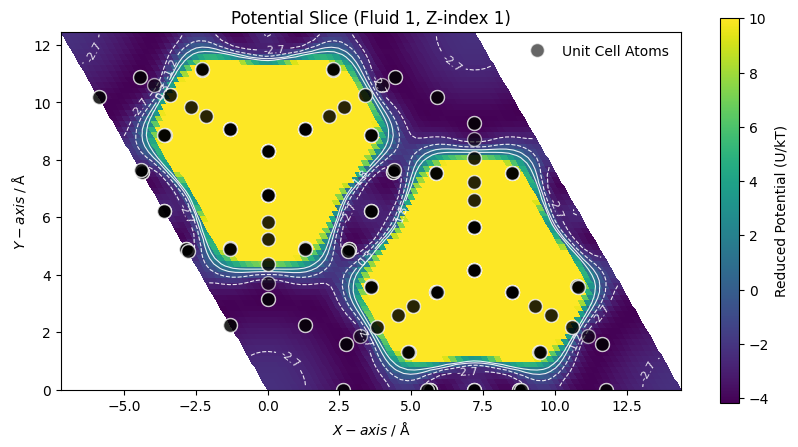

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
framework.visualize_external_potential_contour(
    ax,
    external_potential.reduced_potential(
        temperature=298.15,
        maximum_reduced_energy=10.0
    ),
    fluid_index=1,
    z_index=1,
    num_min_contours=5,
    min_contour_offset=1.5,
)
#plt.title(f"z-slice {i}")
plt.savefig(f"slice_{i:03d}.png", dpi=200)
plt.xlabel("$X-axis\;/\;\mathrm{\AA}$")
plt.ylabel("$Y-axis\;/\;\mathrm{\AA}$")
plt.show()
plt.close()





--- x-lin ---
Columns: ['temperature_kelvin', 'pressure_bar', 'label', 'n_samples', 'pooled_r2', 'bootstrap_std', 'ci95_low', 'ci95_high']
Using R2 column: pooled_r2

--- x-log ---
Columns: ['temperature_kelvin', 'pressure_bar', 'label', 'n_samples', 'pooled_r2', 'bootstrap_std', 'ci95_low', 'ci95_high']
Using R2 column: pooled_r2

--- bolt-lin ---
Columns: ['temperature_kelvin', 'pressure_bar', 'label', 'n_samples', 'pooled_r2', 'bootstrap_std', 'ci95_low', 'ci95_high']
Using R2 column: pressure_bar

--- bolt-log ---
Columns: ['temperature_kelvin', 'pressure_bar', 'label', 'n_samples', 'pooled_r2', 'bootstrap_std', 'ci95_low', 'ci95_high']
Using R2 column: pooled_r2

=== Summary (298 K, 0.1 bar) ===
 variant  n     mean      std   median      q25      q75      min      max      iqr
   x-lin  3 0.695780 0.214129 0.632593 0.576474 0.783492 0.520355 0.934392 0.207018
bolt-log  3 0.695780 0.214129 0.632593 0.576474 0.783492 0.520355 0.934392 0.207018
bolt-lin  4 0.550000 0.519615 0.55000

/var/folders/p_/gl5tyfs92yg7lps1mzt8whdc0000gn/T/ipykernel_75521/2273915047.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showmeans=True)


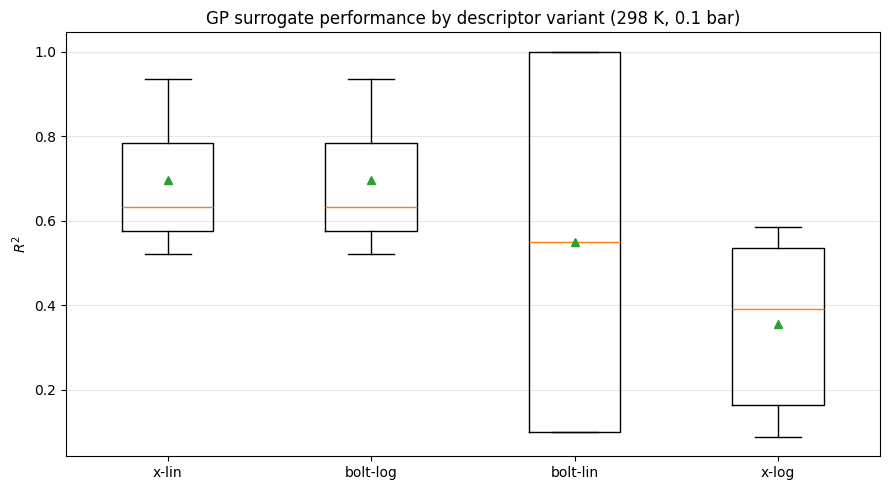

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================
# 1) INPUT FILES
# ============================
files = {
    "x-lin":    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_xlin.csv",
    "x-log":    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_xlog.csv",
    "bolt-lin": "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_boltlin.csv",
    "bolt-log": "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_boltlog.csv",
}

# Folder where the CSVs are located
BASE = Path(".")  # set e.g. Path("/Users/...") if needed

# If you know the exact column name for R^2, set it here (recommended)
R2_COL = None  # e.g. "r2" or "R2" or "test_r2" etc.

# ============================
# 2) LOAD + PICK R2
# ============================
def pick_r2_column(df: pd.DataFrame, preferred: str | None = None) -> str:
    if preferred is not None:
        if preferred not in df.columns:
            raise ValueError(f"R2_COL='{preferred}' not in columns: {df.columns.tolist()}")
        return preferred

    # Try common names
    common = []
    for c in df.columns:
        key = c.lower().replace(" ", "").replace("_", "").replace("^", "")
        if key in ("r2", "rsquared", "r2score", "r2test", "testr2", "valr2", "validr2"):
            common.append(c)
    if common:
        return common[0]

    # Otherwise: choose numeric column with values in a plausible R2 range
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise ValueError(f"No numeric columns in df. Columns: {df.columns.tolist()}")

    # Heuristic: prefer columns that look like R2 (mostly between -1 and 1)
    best = None
    best_score = -np.inf
    for c in num_cols:
        s = df[c].dropna().values
        if len(s) == 0:
            continue
        frac_in_range = np.mean((s >= -2.0) & (s <= 1.0))
        # penalize integer-like columns (often temperature/iteration)
        is_integerish = np.mean(np.isclose(s, np.round(s))) > 0.9
        score = frac_in_range - (0.2 if is_integerish else 0.0)
        if score > best_score:
            best_score = score
            best = c

    if best is None:
        # fall back to first numeric column
        best = num_cols[0]
    return best

all_rows = []
for variant, fname in files.items():
    path = BASE / fname
    df = pd.read_csv(path)

    print(f"\n--- {variant} ---")
    print("Columns:", df.columns.tolist())
    r2_col = pick_r2_column(df, R2_COL)
    print("Using R2 column:", r2_col)

    tmp = pd.DataFrame({
        "variant": variant,
        "R2": df[r2_col].astype(float)
    })
    all_rows.append(tmp)

all_df = pd.concat(all_rows, ignore_index=True)
all_df = all_df[np.isfinite(all_df["R2"])]

# ============================
# 3) SUMMARY TABLE
# ============================
summary = (
    all_df.groupby("variant")["R2"]
    .agg(
        n="count",
        mean="mean",
        std="std",
        median="median",
        q25=lambda s: s.quantile(0.25),
        q75=lambda s: s.quantile(0.75),
        min="min",
        max="max",
    )
    .reset_index()
)
summary["iqr"] = summary["q75"] - summary["q25"]
summary = summary.sort_values("median", ascending=False)

print("\n=== Summary (298 K, 0.1 bar) ===")
print(summary.to_string(index=False))

# Optional: save summary
summary.to_csv("gp_descriptor_variant_summary.csv", index=False)

# ============================
# 4) BOXPLOT FIGURE
# ============================
order = summary["variant"].tolist()
data = [all_df.loc[all_df["variant"] == v, "R2"].values for v in order]

plt.figure(figsize=(9, 5))
plt.boxplot(data, labels=order, showmeans=True)
plt.ylabel(r"$R^2$")
plt.title("GP surrogate performance by descriptor variant (298 K, 0.1 bar)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("gp_descriptor_variant_boxplot.png", dpi=200)
plt.show()


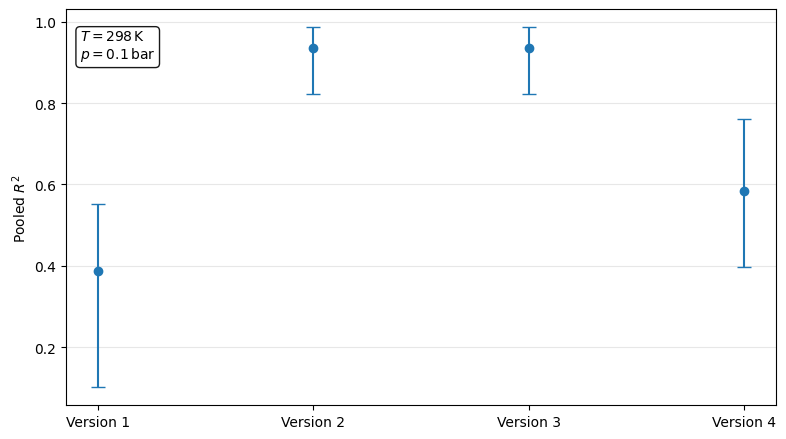

     variant  pooled_r2    ci_low   ci_high    n
0  Version 1   0.388205  0.101605  0.551363  245
1  Version 2   0.934392  0.821339  0.986779  245
2  Version 3   0.934392  0.821339  0.986779  245
3  Version 4   0.584885  0.396646  0.760913  245


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

files = {
    "Version 1": "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_boltlin.csv",
    "Version 2": "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_boltlog.csv",
    "Version 3":    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_xlin.csv",
    "Version 4":    "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log_nodens_ucb_xlog.csv",
}

TEMP = 298
PRES = 0.1

rows = []
for name, fp in files.items():
    df = pd.read_csv(fp)
    # Filter auf den gewünschten Zustand
    df = df[(df["temperature_kelvin"] == TEMP) & (df["pressure_bar"] == PRES)]
    if df.empty:
        raise ValueError(f"No row found for {name} at T={TEMP}, p={PRES} in {fp}")
    # Falls mehrfach geloggt, nimm die letzte Zeile
    r = df.iloc[-1]
    rows.append({
        "variant": name,
        "pooled_r2": r["pooled_r2"],
        "ci_low": r["ci95_low"],
        "ci_high": r["ci95_high"],
        "n": r.get("n_samples", None)
    })

res = pd.DataFrame(rows).set_index("variant").loc[["Version 1","Version 2","Version 3","Version 4"]].reset_index()

# Plot: point + CI
plt.figure(figsize=(8,4.5))
x = range(len(res))
y = res["pooled_r2"].values
yerr = [y - res["ci_low"].values, res["ci_high"].values - y]

plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=5)
plt.text(
    0.02, 0.95,
    r"$T = 298\,\mathrm{K}$" + "\n" + r"$p = 0.1\,\mathrm{bar}$",
    transform=plt.gca().transAxes,
    ha="left",
    va="top",
    bbox=dict(
        boxstyle="round",
        facecolor="white",
        edgecolor="black",
        alpha=0.9
    )
)
plt.xticks(x, res["variant"])
plt.ylabel(r"Pooled $R^2$")
#plt.title(f"GP performance at {TEMP} K and {PRES} bar")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("gp_descriptor_variant_boxplot_fresh.png", dpi=200)
plt.show()

print(res)


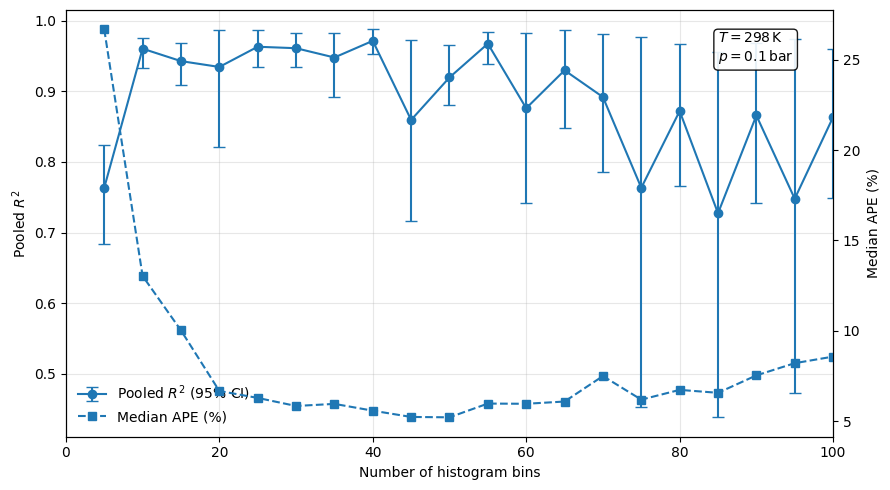

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# CONFIG: set your results file here
# ============================================================
RESULTS_FILE = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_bin_screening_T298_p0p1.csv"

TEMP = 298
PRESSURE = 0.1

# ============================================================
# LOAD + FILTER
# ============================================================
df = pd.read_csv(RESULTS_FILE)

# keep only the state you want
df = df[(df["temperature_kelvin"] == TEMP) & (df["pressure_bar"] == PRESSURE)].copy()

# in case you appended multiple runs per n_bins, keep the last entry per n_bins
df = df.sort_values(["n_bins"]).groupby("n_bins", as_index=False).tail(1)

# sort for plotting
df = df.sort_values("n_bins")

x = df["n_bins"].to_numpy()
r2 = df["pooled_r2"].to_numpy()
ci_low = df["ci95_low"].to_numpy()
ci_high = df["ci95_high"].to_numpy()
mdape = df["mdape_percent"].to_numpy()

# error bars for R2
r2_err = np.vstack([r2 - ci_low, ci_high - r2])

# ============================================================
# PLOT: two y-axes (R2 left with CI, MDAPE right)
# ============================================================
fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: R2 with uncertainty
ax1.errorbar(
    x, r2,
    yerr=r2_err,
    fmt="o-",
    capsize=4,
    label=r"Pooled $R^2$ (95% CI)"
)
ax1.set_xlabel("Number of histogram bins")
ax1.set_ylabel(r"Pooled $R^2$")
ax1.grid(True, axis="both", alpha=0.3)

# Optional: force x-axis 0..100 as requested
ax1.set_xlim(0, 100)

# Right axis: Median APE
ax2 = ax1.twinx()
ax2.plot(
    x, mdape,
    marker="s",
    linestyle="--",
    label="Median APE (%)"
)
ax2.set_ylabel("Median APE (%)")

# ============================================================
# Combined legend (both axes)
# ============================================================
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc="best")

# Optional: info box top-left
ax1.text(
    0.85, 0.95,
    rf"$T = {TEMP}\,\mathrm{{K}}$" + "\n" + rf"$p = {PRESSURE}\,\mathrm{{bar}}$",
    transform=ax1.transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="black", alpha=0.9)
)

plt.tight_layout()
plt.savefig("gp_bin_screening_r2_mdape_T298_p0p1.png", dpi=200)
plt.show()


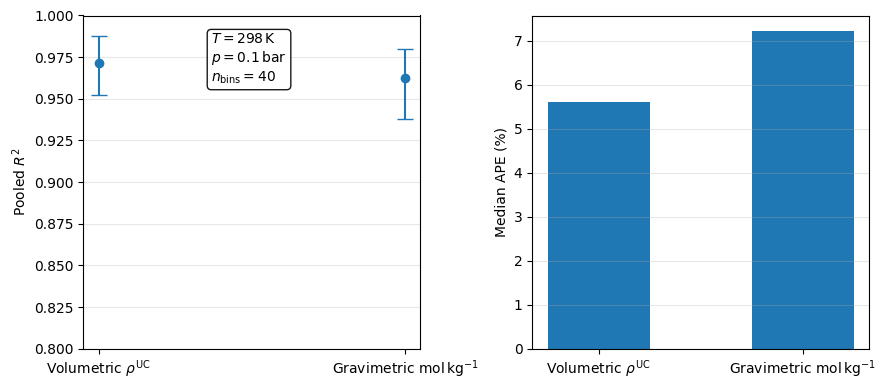

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
RESULTS_FILE = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_label_compare_bin_screening_T298_p0p1.csv"

TEMP = 298
PRESSURE = 0.1
N_BINS = 40   # <- fixed

LABEL_A = "beladung_pro_vol"
LABEL_B = "beladung_mol_per_kg"

# ============================================================
# LOAD + FILTER
# ============================================================
df = pd.read_csv(RESULTS_FILE)

df = df[
    (df["temperature_kelvin"] == TEMP) &
    (df["pressure_bar"] == PRESSURE) &
    (df["n_bins"] == N_BINS)
].copy()

# ensure one row per label
df = df.sort_values("label").groupby("label", as_index=False).tail(1)

# order labels manually
labels = [LABEL_A, LABEL_B]
df["label"] = pd.Categorical(df["label"], categories=labels, ordered=True)
df = df.sort_values("label")

# data
x = np.arange(len(labels))
r2 = df["pooled_r2"].values
ci_low = df["ci95_low"].values
ci_high = df["ci95_high"].values
mdape = df["mdape_percent"].values

r2_err = np.vstack([r2 - ci_low, ci_high - r2])

# ============================================================
# FIGURE
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# --- R2 panel ---
ax1.errorbar(
    x, r2,
    yerr=r2_err,
    fmt="o",
    capsize=6
)
ax1.set_xticks(x)
ax1.set_xticklabels([
    r"Volumetric $\rho^{\mathrm{UC}}$",
    r"Gravimetric $\mathrm{mol}\,\mathrm{kg}^{-1}$"
])
ax1.set_ylabel(r"Pooled $R^2$")
ax1.set_ylim(0.8, 1.0)
ax1.grid(True, axis="y", alpha=0.3)

# --- MDAPE panel ---
ax2.bar(
    x, mdape,
    width=0.5
)
ax2.set_xticks(x)
ax2.set_xticklabels([
    r"Volumetric $\rho^{\mathrm{UC}}$",
    r"Gravimetric $\mathrm{mol}\,\mathrm{kg}^{-1}$"
])

ax2.set_ylabel("Median APE (%)")
ax2.grid(True, axis="y", alpha=0.3)

# info box
ax1.text(
    0.38, 0.95,
    rf"$T = {TEMP}\,\mathrm{{K}}$" + "\n" +
    rf"$p = {PRESSURE}\,\mathrm{{bar}}$" + "\n" +
    rf"$n_{{\mathrm{{bins}}}} = {N_BINS}$",
    transform=ax1.transAxes,
    ha="left", va="top",
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="black", alpha=0.9)
)

plt.tight_layout()
plt.savefig("gp_label_comparison_40bins_T298_p0p1.png", dpi=200)
plt.show()


df_bo columns: ['seed', 'temperature_kelvin', 'pressure_bar', 'label', 'n_candidates', 'init_strategy', 'n_initial', 'initial_structures', 'max_iter', 'patience', 'global_best', 'acq', 'run_id', 'method', 'acq_param_last', 'iters_done', 'stopped_early', 'final_best', 'ratio_to_optimum', 'found_global_best', 'state', 'strategy']
strategies in df_bo: strategy
bo_['ucb', 'ei']    60
random              60
Name: count, dtype: int64
strategies in df_hist: strategy
bo_ucb    887
random    852
Name: count, dtype: int64
states in df_bo: ['T=298K,p=1bar', 'T=348K,p=1bar', 'T=400K,p=1bar']


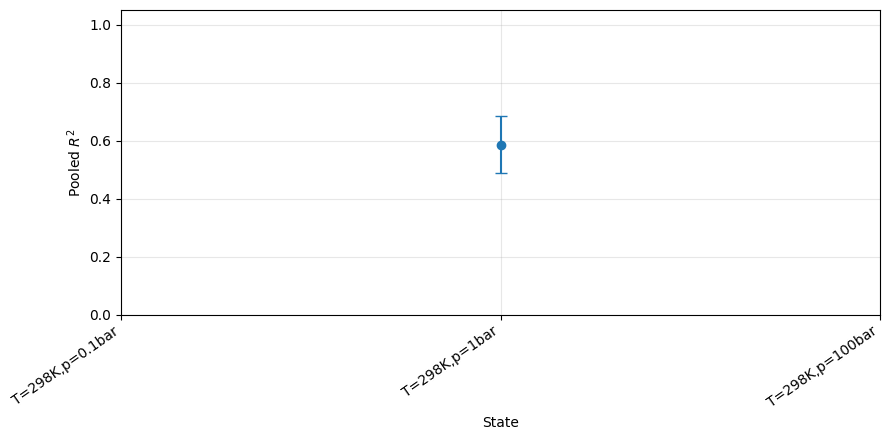

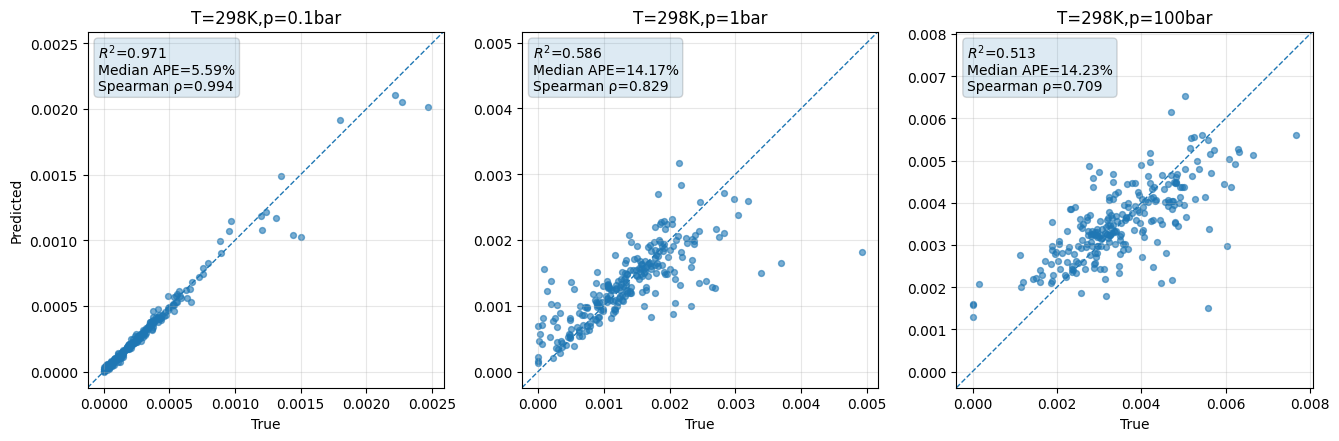

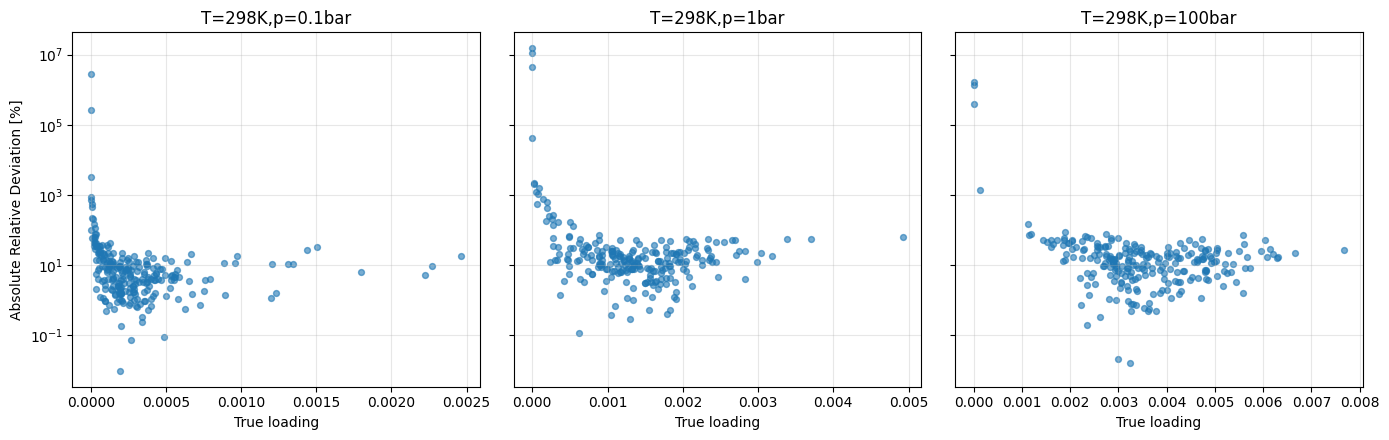

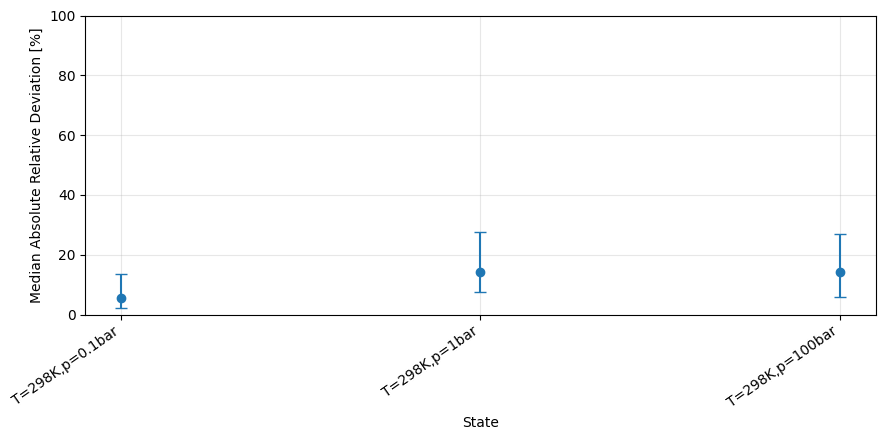

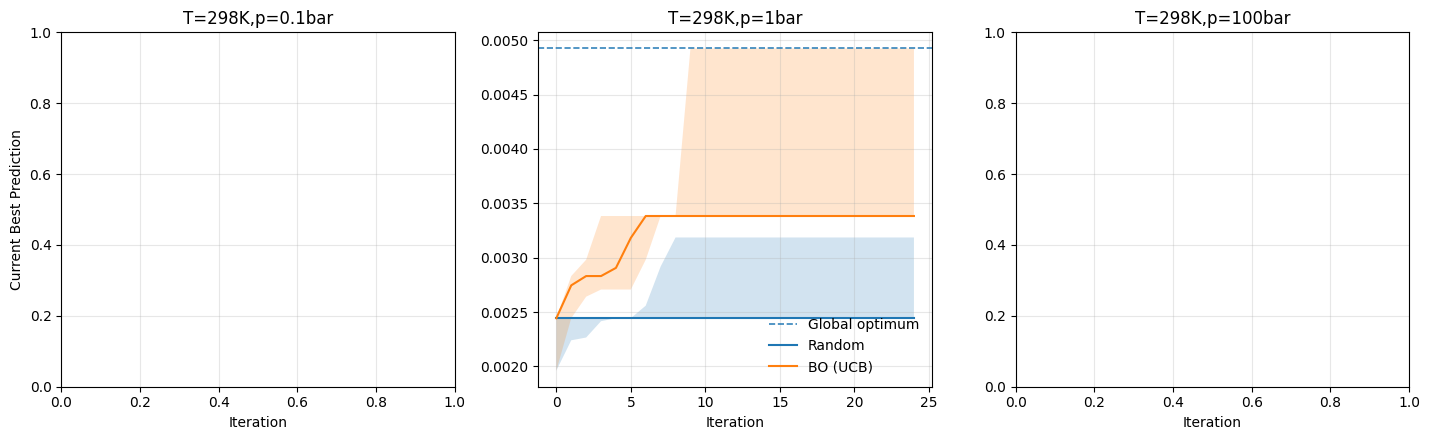

/var/folders/p_/gl5tyfs92yg7lps1mzt8whdc0000gn/T/ipykernel_9865/2564649001.py:376: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc="lower right")


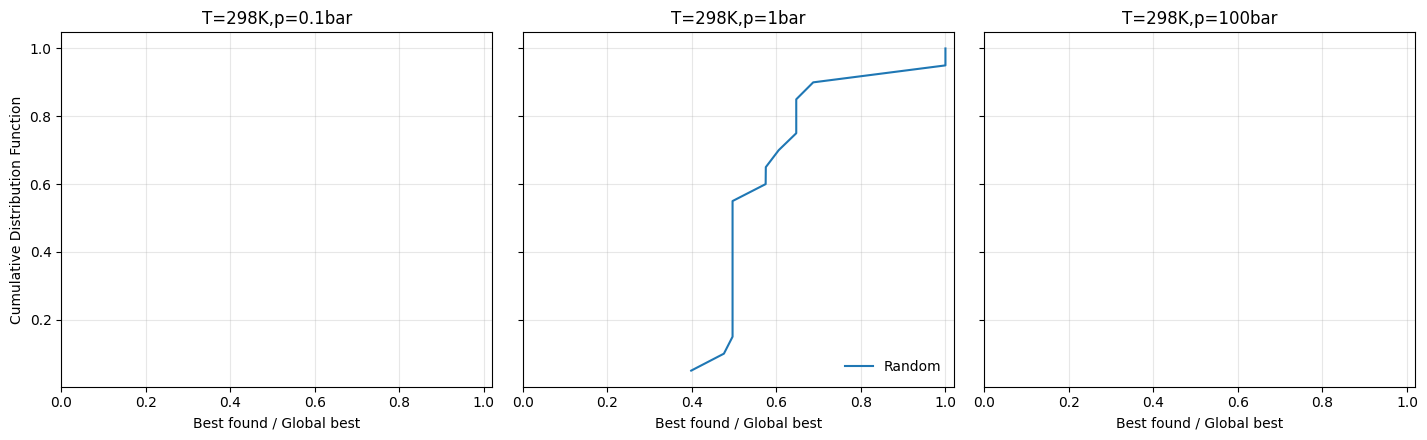

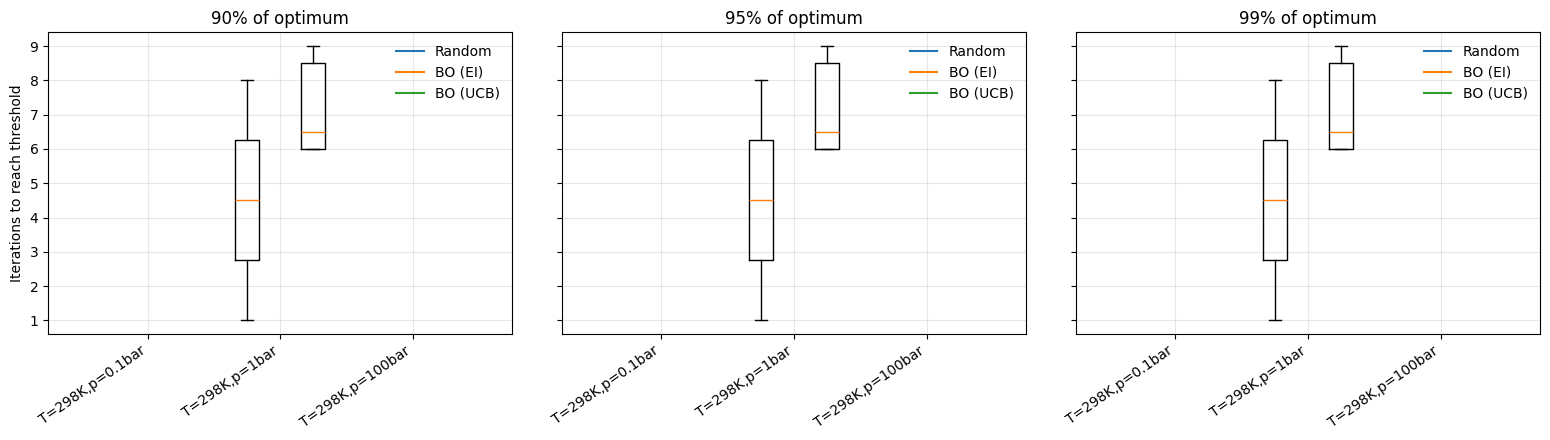

In [5]:
# ============================================================
# CODE 2 — PLOTTING (GP pooled R2 + parity/ARD + BO(Random/EI/UCB))
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ----------------------------
# CONFIG
# ----------------------------
BASE = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv")

TEMP = [298]
PRESSURES = [0.1, 1.0, 100.0]
LABEL = "beladung_pro_vol"

POOLED_LOG = BASE / "gp_pooled_r2_log_nodens_ucb_40fresh_vol_new_1bar.csv"
BO_RESULTS = BASE / "bo_random_results_nodens_ucb_40fresh_vol_new_1bar.csv"
BO_HISTORY = BASE / "bo_random_history_nodens_ucb_40fresh_vol_new_1bar.csv"

# ----------------------------
# Helpers
# ----------------------------
def state_label(t, p):
    return f"T={float(t):.0f}K,p={float(p):g}bar"

def load_oof(t, p):
    f = BASE / f"oof_T{t}_p{p:g}.csv"
    df = pd.read_csv(f)
    df["temperature_kelvin"] = float(t)
    df["pressure_bar"] = float(p)
    df["state"] = state_label(t, p)
    return df

states = [state_label(TEMP, p) for p in PRESSURES]

def ensure_temp_pressure_and_state(df):
    df = df.copy()
    if "temperature_kelvin" not in df.columns or "pressure_bar" not in df.columns:
        raise ValueError("DataFrame needs columns: 'temperature_kelvin' and 'pressure_bar'")

    df["temperature_kelvin"] = pd.to_numeric(df["temperature_kelvin"], errors="coerce")
    df["pressure_bar"] = pd.to_numeric(df["pressure_bar"], errors="coerce")
    df["state"] = df.apply(lambda r: state_label(r["temperature_kelvin"], r["pressure_bar"]), axis=1)
    df["state"] = df["state"].astype(str).str.strip()
    return df

def ensure_method(df, default="bo"):
    df = df.copy()
    if "method" not in df.columns:
        df["method"] = default

    df["method"] = df["method"].astype(str).str.strip().str.lower()
    df.loc[df["method"].isin(["bayes", "bayesian", "ucb", "ei"]), "method"] = "bo"
    df.loc[df["method"].isin(["rand", "random", "uniform"]), "method"] = "random"
    return df

def ensure_acq(df, default_for_bo="ucb"):
    df = df.copy()
    if "acq" not in df.columns:
        df["acq"] = np.nan

    df = ensure_method(df)

    df["acq"] = df["acq"].astype(str).str.strip().str.lower()
    df.loc[df["acq"].isin(["nan", "none", "null", ""]), "acq"] = np.nan

    df.loc[df["method"] == "random", "acq"] = "none"
    df.loc[(df["method"] == "bo") & (df["acq"].isna()), "acq"] = default_for_bo

    df.loc[df["acq"].isin(["expectedimprovement", "exp_imp"]), "acq"] = "ei"
    df.loc[df["acq"].isin(["upperconfidencebound", "upper_confidence_bound"]), "acq"] = "ucb"
    return df

def add_strategy(df):
    df = df.copy()
    df = ensure_method(df)
    df = ensure_acq(df)
    df["strategy"] = np.where(df["method"] == "random", "random", "bo_" + df["acq"].astype(str))
    return df

# ----------------------------
# Load data
# ----------------------------
df_r2 = pd.read_csv(POOLED_LOG)
df_bo = pd.read_csv(BO_RESULTS)
df_hist = pd.read_csv(BO_HISTORY)

# label filters if present
if "label" in df_r2.columns:
    df_r2 = df_r2[df_r2["label"] == LABEL].copy()
if "label" in df_bo.columns:
    df_bo = df_bo[df_bo["label"] == LABEL].copy()
if "label" in df_hist.columns:
    df_hist = df_hist[df_hist["label"] == LABEL].copy()

# normalize: always generate state from numeric columns
df_r2 = ensure_temp_pressure_and_state(df_r2)
df_bo = add_strategy(ensure_temp_pressure_and_state(df_bo))
df_hist = add_strategy(ensure_temp_pressure_and_state(df_hist))

# fix columns in history
if "iter" not in df_hist.columns:
    for cand in ["iteration", "step"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "iter"})
            break
if "best_so_far" not in df_hist.columns:
    for cand in ["best", "best_value", "best_sofar"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "best_so_far"})
            break

df_hist["iter"] = pd.to_numeric(df_hist["iter"], errors="coerce")
df_hist["best_so_far"] = pd.to_numeric(df_hist["best_so_far"], errors="coerce")

# load OOFs
oof_all = pd.concat([load_oof(TEMP, p) for p in PRESSURES], ignore_index=True)

if "abs_rel_deviation" not in oof_all.columns:
    oof_all["abs_rel_deviation"] = np.abs((oof_all[LABEL] - oof_all[f"{LABEL}_pred"]) / oof_all[LABEL]) * 100

# --- optional debug ---
print("df_bo columns:", df_bo.columns.tolist())
print("strategies in df_bo:", df_bo["strategy"].value_counts(dropna=False))
print("strategies in df_hist:", df_hist["strategy"].value_counts(dropna=False))
print("states in df_bo:", sorted(df_bo["state"].unique().tolist()))

# ============================================================
# PLOT 1: pooled R² + CI per state
# ============================================================
def plot_pooled_r2_ci(df_r2, outfile=BASE/"01_pooled_r2_ci_nodens_40fresh_vol.png"):
    d = ensure_temp_pressure_and_state(df_r2)
    d = d[d["temperature_kelvin"] == float(TEMP)].copy()
    d = d.set_index("state").reindex(states).reset_index()

    x = np.arange(len(d))
    y = d["pooled_r2"].to_numpy()
    yerr = np.vstack([y - d["ci95_low"].to_numpy(), d["ci95_high"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Pooled $R^2$")
    plt.xlabel("State")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 2: Parity plots (per state)
# ============================================================
def plot_parity_panels(oof_all, outfile=BASE/"02_parity_panels_nodens_40fresh_vol.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(4.5 * len(states), 4.5))
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        y_true = df[LABEL].to_numpy()
        y_pred = df[f"{LABEL}_pred"].to_numpy()

        mn = min(np.nanmin(y_true), np.nanmin(y_pred))
        mx = max(np.nanmax(y_true), np.nanmax(y_pred))
        span = mx - mn
        pad = 0.05 * span if span > 0 else 1e-6
        lo = mn - pad
        hi = mx + pad

        ax.scatter(y_true, y_pred, s=18, alpha=0.6)
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)
        mdape = np.nanmedian(df["abs_rel_deviation"].to_numpy())
        rho, _ = spearmanr(y_true, y_pred)

        ax.set_title(st)
        ax.set_xlabel("True")
        ax.grid(alpha=0.3)

        ax.text(
            0.03, 0.97,
            f"$R^2$={r2:.3f}\nMedian APE={mdape:.2f}%\nSpearman ρ={rho:.3f}",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round", alpha=0.15)
        )

    axs[0].set_ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3A: ARD scatter log-y
# ============================================================
def plot_ard_scatter_logy(oof_all, outfile=BASE/"03a_ard_scatter_logy_nodens_40fresh_vol.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(14, 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        ax.scatter(df[LABEL], df["abs_rel_deviation"], s=18, alpha=0.6)
        ax.set_title(st)
        ax.set_xlabel("True loading")
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    axs[0].set_ylabel("Absolute Relative Deviation [%]")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3B: Median + IQR ARD per state
# ============================================================
def plot_ard_median_iqr(oof_all, outfile=BASE/"03b_ard_median_iqr_nodens_40fresh_vol.png"):
    rows = []
    for st in states:
        df = oof_all[oof_all["state"] == st]
        if df.empty:
            rows.append((st, np.nan, np.nan, np.nan))
            continue
        med = df["abs_rel_deviation"].median()
        q25 = df["abs_rel_deviation"].quantile(0.25)
        q75 = df["abs_rel_deviation"].quantile(0.75)
        rows.append((st, med, q25, q75))

    d = pd.DataFrame(rows, columns=["state", "median", "q25", "q75"])
    x = np.arange(len(d))

    y = d["median"].to_numpy()
    yerr = np.vstack([y - d["q25"].to_numpy(), d["q75"].to_numpy() - y])

    plt.figure(figsize=(9, 4.5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.xticks(x, d["state"], rotation=35, ha="right")
    plt.ylabel("Median Absolute Relative Deviation [%]")
    plt.xlabel("State")
    plt.ylim(0, 100)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 4: Best-so-far vs Iteration (Random vs BO(EI) vs BO(UCB)) + global optimum line
# ============================================================
def plot_best_so_far_curves(df_hist, df_bo, states,
                            outfile=BASE/"04_best_so_far_random_ei_ucb_nodens_40fresh_vol.png"):
    dh = add_strategy(ensure_temp_pressure_and_state(df_hist))
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "strategy", "temperature_kelvin", "pressure_bar"}
    miss_h = req_h.difference(dh.columns)
    if miss_h:
        raise ValueError(f"df_hist missing columns: {miss_h}")

    req_b = {"global_best", "state"}
    miss_b = req_b.difference(db.columns)
    if miss_b:
        raise ValueError(f"df_bo missing columns: {miss_b}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty:
        print("No history rows found for the selected states.")
        return

    gb = db.groupby("state")["global_best"].median().to_dict()

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["state"] == st].copy()

        if st in gb and np.isfinite(gb[st]):
            ax.axhline(gb[st], linestyle="--", linewidth=1.2, alpha=0.9, label="Global optimum")

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            ax.plot(np.arange(max_iter + 1), median, label=pretty)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)

        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 5: CDF of ratio_to_optimum (Random vs BO(EI) vs BO(UCB)) per state
# ============================================================
def plot_ratio_cdf(df_bo, states, outfile=BASE/"05_ratio_cdf_random_ei_ucb_nodens_40fresh_vol.png"):
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    required = {"strategy", "ratio_to_optimum", "temperature_kelvin", "pressure_bar", "state"}
    missing = required.difference(db.columns)
    if missing:
        raise ValueError(f"df_bo missing columns: {missing}")

    db = db[db["state"].isin(states)].copy()
    if db.empty:
        print("No result rows found for selected states.")
        return

    fig, axs = plt.subplots(1, len(states), figsize=(4.8 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = db[db["state"] == st].copy()

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            vals = sub[sub["strategy"] == strat]["ratio_to_optimum"].dropna().to_numpy()
            if len(vals) == 0:
                continue
            vals = np.sort(vals)
            y = np.arange(1, len(vals) + 1) / len(vals)
            ax.plot(vals, y, label=pretty)

        ax.set_title(st)
        ax.set_xlabel("Best found / Global best")
        ax.set_xlim(0, 1.02)
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Cumulative Distribution Function")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 6: Time-to-threshold (Random vs BO(EI) vs BO(UCB))
# ============================================================
def plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99),
                           outfile=BASE/"06_time_to_threshold_random_ei_ucb_nodens_40fresh_vol.png"):
    dh = add_strategy(ensure_temp_pressure_and_state(df_hist))
    db = add_strategy(ensure_temp_pressure_and_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "state", "strategy"}
    req_b = {"state", "global_best"}
    if req_h.difference(dh.columns):
        raise ValueError(f"df_hist missing columns: {req_h.difference(dh.columns)}")
    if req_b.difference(db.columns):
        raise ValueError(f"df_bo missing columns: {req_b.difference(db.columns)}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty or db.empty:
        print("No data for time-to-threshold after filtering.")
        return

    gb = db.groupby("state")["global_best"].median().to_dict()

    rows = []
    for st in states:
        if st not in gb or gb[st] == 0 or np.isnan(gb[st]):
            continue
        gbest = gb[st]
        sub = dh[dh["state"] == st].copy()

        for strat in ["random", "bo_ei", "bo_ucb"]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            for run_id, grp in m.groupby("run_id"):
                grp = grp.sort_values("iter")
                for thr in thresholds:
                    target = thr * gbest
                    hit = grp[grp["best_so_far"] >= target]
                    it = float(hit["iter"].iloc[0]) if len(hit) else np.nan
                    rows.append({"state": st, "strategy": strat, "threshold": thr, "iters_to_thr": it})

    d = pd.DataFrame(rows).dropna(subset=["iters_to_thr"])
    if d.empty:
        print("No threshold hits found.")
        return

    fig, axs = plt.subplots(1, len(thresholds), figsize=(5.2 * len(thresholds), 4.5), sharey=True)
    if len(thresholds) == 1:
        axs = [axs]

    for ax, thr in zip(axs, thresholds):
        sub = d[d["threshold"] == thr]

        x = np.arange(len(states))
        w = 0.25

        data_random = [sub[(sub["state"] == st) & (sub["strategy"] == "random")]["iters_to_thr"].to_numpy() for st in states]
        data_ei     = [sub[(sub["state"] == st) & (sub["strategy"] == "bo_ei")]["iters_to_thr"].to_numpy() for st in states]
        data_ucb    = [sub[(sub["state"] == st) & (sub["strategy"] == "bo_ucb")]["iters_to_thr"].to_numpy() for st in states]

        ax.boxplot(data_random, positions=x - w, widths=0.18, showfliers=False)
        ax.boxplot(data_ei,     positions=x,     widths=0.18, showfliers=False)
        ax.boxplot(data_ucb,    positions=x + w, widths=0.18, showfliers=False)

        ax.set_xticks(x)
        ax.set_xticklabels(states, rotation=35, ha="right")
        ax.set_title(f"{int(thr*100)}% of optimum")
        ax.grid(alpha=0.3)

        ax.plot([], [], label="Random")
        ax.plot([], [], label="BO (EI)")
        ax.plot([], [], label="BO (UCB)")
        ax.legend(frameon=False, loc="upper right")

    axs[0].set_ylabel("Iterations to reach threshold")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# RUN PLOTS
# ============================================================
plot_pooled_r2_ci(df_r2)
plot_parity_panels(oof_all)
plot_ard_scatter_logy(oof_all)
plot_ard_median_iqr(oof_all)
plot_best_so_far_curves(df_hist, df_bo, states)
plot_ratio_cdf(df_bo, states)
plot_time_to_threshold(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99))


df_bo columns: ['seed', 'temp_high', 'pres_high', 'temp_low', 'pres_low', 'wc_state', 'label', 'n_candidates', 'init_strategy', 'n_initial', 'initial_structures', 'max_iter', 'patience', 'global_best', 'run_id', 'method', 'acq', 'acq_param_last', 'iters_done', 'stopped_early', 'final_best', 'ratio_to_optimum', 'found_global_best', 'strategy']
strategies in df_bo: strategy
random    60
bo_ucb    60
bo_ei     60
Name: count, dtype: int64
strategies in df_hist: strategy
bo_ucb    852
bo_ei     847
random    768
Name: count, dtype: int64
wc_states in df_bo: ['(T=298K,p=1)-(T=298K,p=0.1)', '(T=298K,p=5)-(T=298K,p=1)', '(T=400K,p=1)-(T=298K,p=1)']


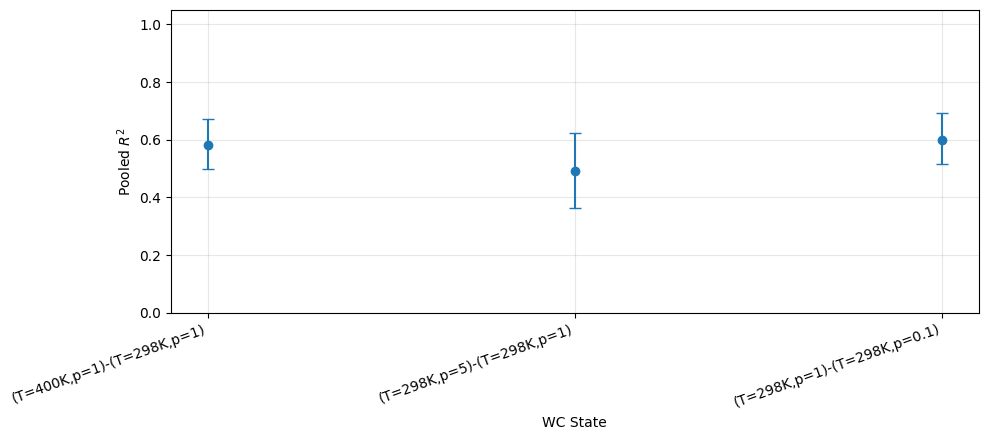

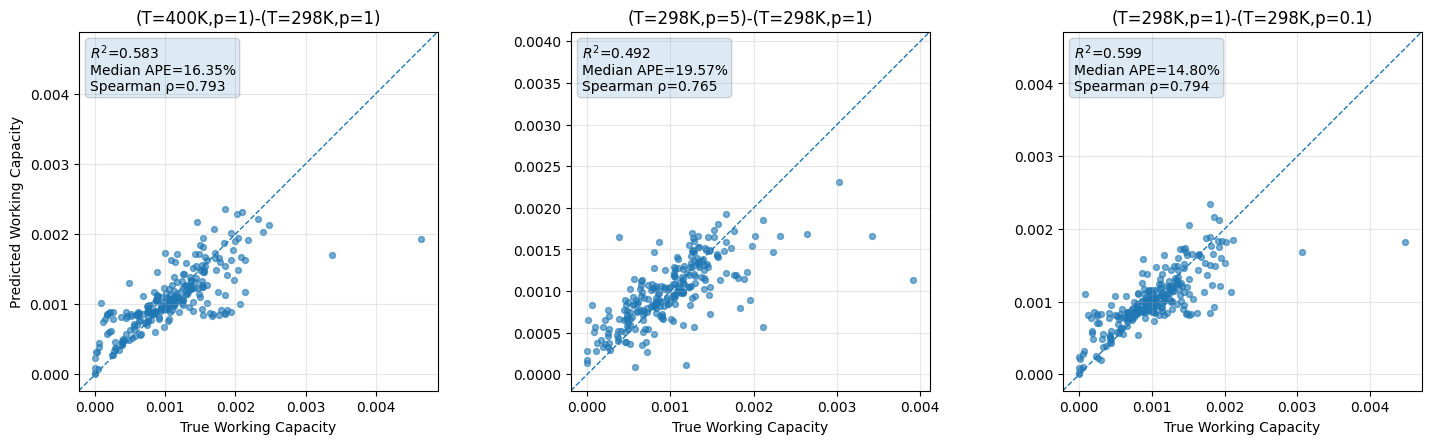

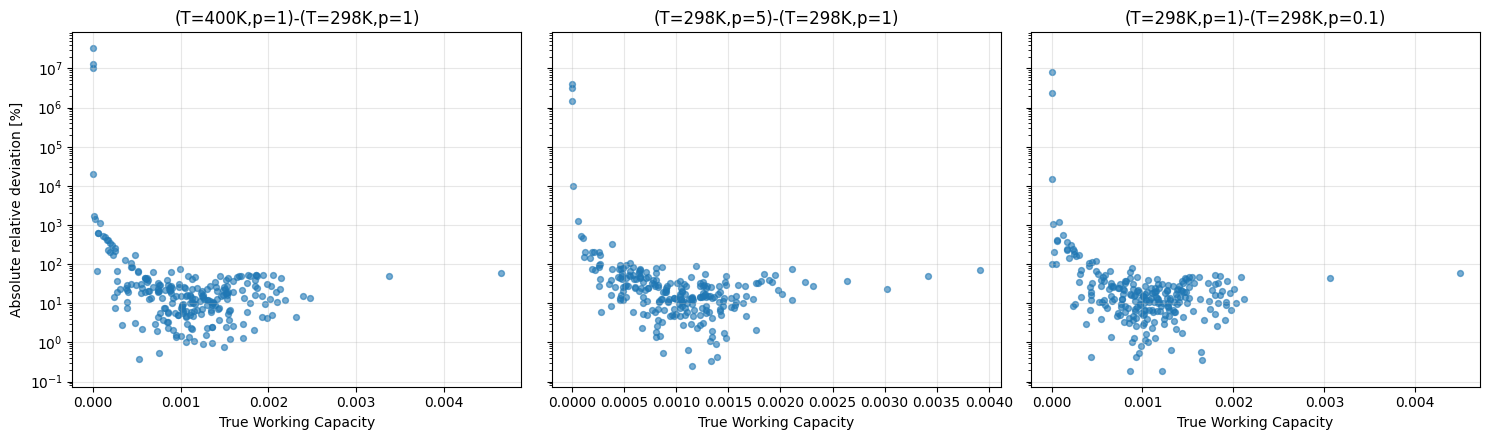

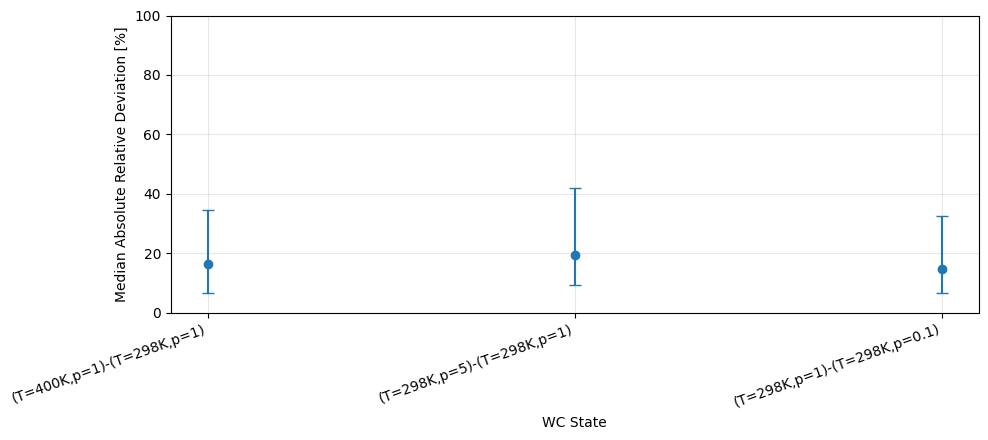

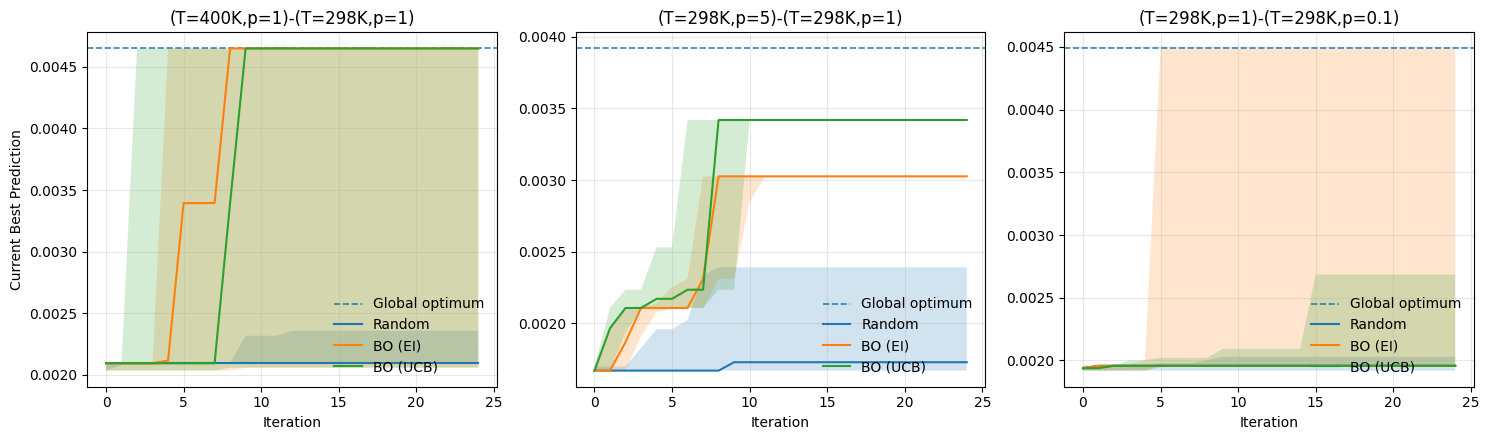

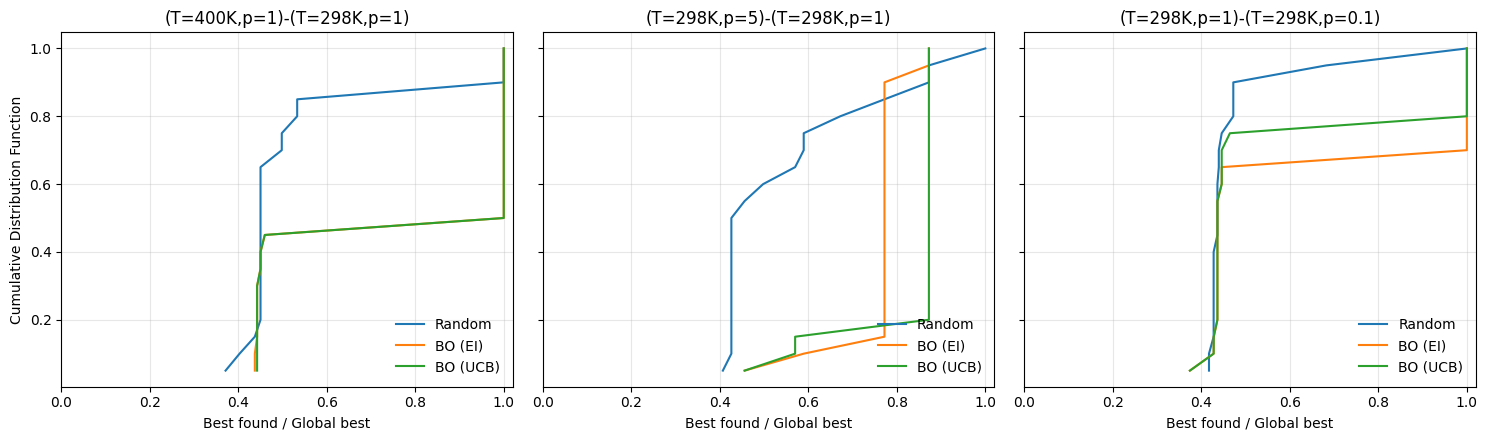

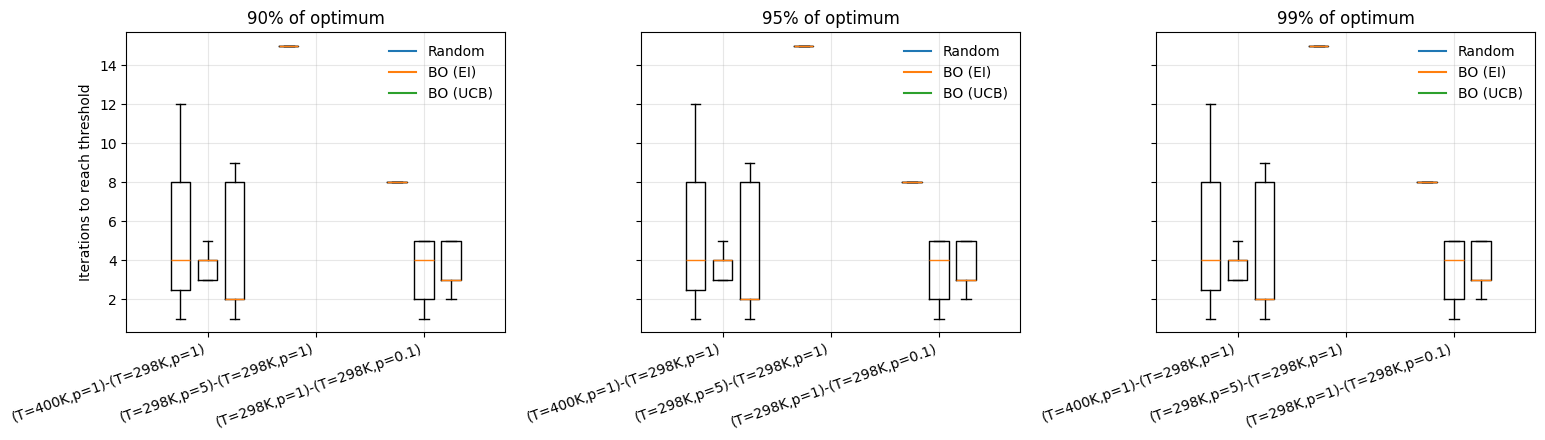

In [74]:
# ============================================================
# WORKING CAPACITY — PLOTTING (Random vs BO(EI) vs BO(UCB))
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

# ----------------------------
# CONFIG
# ----------------------------
BASE = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv")

LABEL = "working_capacity"

# use the NEW acq-neutral filenames from the adapted generator
POOLED_LOG = BASE / "gp_pooled_r2_log_wc_dens_20fresh.csv"
BO_RESULTS = BASE / "bo_random_results_wc_dens_20fresh.csv"
BO_HISTORY = BASE / "bo_random_history_wc_dens_20fresh.csv"

# WC states must match what you used in training
# (temp_high, pres_high, temp_low, pres_low)
WC_STATES = [
    (400.0, 1.0, 298.0, 1.0),
    (298.0, 5.0, 298.0, 1.0),
    (298.0, 1.0, 298.0, 0.1),
]

# ----------------------------
# Helpers
# ----------------------------
def wc_state_label(tH, pH, tL, pL):
    return f"(T={float(tH):.0f}K,p={float(pH):g})-(T={float(tL):.0f}K,p={float(pL):g})"

def load_oof_wc(tH, pH, tL, pL):
    f = BASE / f"oof_wc_TH{tH:g}_pH{pH:g}_TL{tL:g}_pL{pL:g}.csv"
    df = pd.read_csv(f)
    df["temp_high"] = float(tH)
    df["pres_high"] = float(pH)
    df["temp_low"]  = float(tL)
    df["pres_low"]  = float(pL)
    df["wc_state"]  = wc_state_label(tH, pH, tL, pL)
    return df

def ensure_wc_state(df):
    df = df.copy()

    for c in ["temp_high", "pres_high", "temp_low", "pres_low"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "wc_state" not in df.columns and {"temp_high","pres_high","temp_low","pres_low"}.issubset(df.columns):
        df["wc_state"] = df.apply(
            lambda r: wc_state_label(r["temp_high"], r["pres_high"], r["temp_low"], r["pres_low"]), axis=1
        )

    if "wc_state" in df.columns:
        df["wc_state"] = df["wc_state"].astype(str).str.strip()

    return df

def ensure_method(df, default="bo"):
    df = df.copy()
    if "method" not in df.columns:
        df["method"] = default

    df["method"] = df["method"].astype(str).str.strip().str.lower()
    df.loc[df["method"].isin(["bayes", "bayesian", "ucb", "ei"]), "method"] = "bo"
    df.loc[df["method"].isin(["rand", "random", "uniform"]), "method"] = "random"
    return df

def ensure_acq(df, default_for_bo="ucb"):
    """
    Ensures an 'acq' column exists and is normalized:
      - bo rows: acq in {"ei","ucb"} (fallback default_for_bo if missing)
      - random rows: acq="none"
    """
    df = df.copy()
    if "acq" not in df.columns:
        df["acq"] = np.nan

    df = ensure_method(df)

    df["acq"] = df["acq"].astype(str).str.strip().str.lower()
    df.loc[df["acq"].isin(["nan", "none", "null", ""]), "acq"] = np.nan

    df.loc[df["method"] == "random", "acq"] = "none"
    df.loc[(df["method"] == "bo") & (df["acq"].isna()), "acq"] = default_for_bo

    df.loc[df["acq"].isin(["expectedimprovement", "exp_imp"]), "acq"] = "ei"
    df.loc[df["acq"].isin(["upperconfidencebound", "upper_confidence_bound"]), "acq"] = "ucb"
    return df

def add_strategy(df):
    """
    Adds strategy labels for plotting:
      - random
      - bo_ei
      - bo_ucb
    """
    df = df.copy()
    df = ensure_method(df)
    df = ensure_acq(df)
    df["strategy"] = np.where(df["method"] == "random", "random", "bo_" + df["acq"].astype(str))
    return df

# consistent state order for plotting
states = [wc_state_label(*tpl) for tpl in WC_STATES]

# ----------------------------
# Load data
# ----------------------------
df_r2   = pd.read_csv(POOLED_LOG)
df_bo   = pd.read_csv(BO_RESULTS)
df_hist = pd.read_csv(BO_HISTORY)

# label filters if present
if "label" in df_r2.columns:
    df_r2 = df_r2[df_r2["label"] == LABEL].copy()
if "label" in df_bo.columns:
    df_bo = df_bo[df_bo["label"] == LABEL].copy()
if "label" in df_hist.columns:
    df_hist = df_hist[df_hist["label"] == LABEL].copy()

# normalize + add strategy
df_r2   = ensure_wc_state(df_r2)
df_bo   = add_strategy(ensure_wc_state(df_bo))
df_hist = add_strategy(ensure_wc_state(df_hist))

# fix columns in history (if needed)
if "iter" not in df_hist.columns:
    for cand in ["iteration", "step"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "iter"})
            break
if "best_so_far" not in df_hist.columns:
    for cand in ["best", "best_value", "best_sofar"]:
        if cand in df_hist.columns:
            df_hist = df_hist.rename(columns={cand: "best_so_far"})
            break

df_hist["iter"] = pd.to_numeric(df_hist["iter"], errors="coerce")
df_hist["best_so_far"] = pd.to_numeric(df_hist["best_so_far"], errors="coerce")

# --- debug prints ---
print("df_bo columns:", df_bo.columns.tolist())
print("strategies in df_bo:", df_bo["strategy"].value_counts(dropna=False))
print("strategies in df_hist:", df_hist["strategy"].value_counts(dropna=False))
print("wc_states in df_bo:", sorted(df_bo["wc_state"].unique().tolist()) if "wc_state" in df_bo.columns else "(no wc_state)")

# load OOFs for all WC states
oof_all = pd.concat([load_oof_wc(*tpl) for tpl in WC_STATES], ignore_index=True)

# ensure abs rel deviation exists (guard against zeros)
if "abs_rel_deviation" not in oof_all.columns:
    denom = oof_all[LABEL].replace(0, np.nan)
    oof_all["abs_rel_deviation"] = np.abs((oof_all[LABEL] - oof_all[f"{LABEL}_pred"]) / denom) * 100

# ============================================================
# PLOT 1: pooled R² + CI per WC state (handles duplicates safely)
# ============================================================
def plot_pooled_r2_ci_wc(df_r2, outfile=BASE/"01_pooled_r2_ci_wc2.png"):
    d = ensure_wc_state(df_r2)

    if "label" in d.columns:
        d = d[d["label"] == LABEL].copy()

    # ---- FIX: state may have duplicates because log is appended ----
    # keep last row per wc_state in file order
    d = d.dropna(subset=["wc_state", "pooled_r2", "ci95_low", "ci95_high"]).copy()
    d = d.groupby("wc_state", as_index=False).tail(1)

    d = d.set_index("wc_state").reindex(states).reset_index()

    x = np.arange(len(d))
    y = d["pooled_r2"].to_numpy()

    yerr = np.vstack([
        y - d["ci95_low"].to_numpy(),
        d["ci95_high"].to_numpy() - y
    ])

    mask = np.isfinite(y)

    plt.figure(figsize=(10, 4.5))
    plt.errorbar(x[mask], y[mask], yerr=yerr[:, mask], fmt="o", capsize=4)
    plt.xticks(x, d["wc_state"], rotation=20, ha="right")
    plt.ylabel("Pooled $R^2$")
    plt.xlabel("WC State")
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 2: Parity plots (per WC state)
# ============================================================
def plot_parity_panels_wc(oof_all, outfile=BASE/"02_parity_panels_wc2.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5))
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["wc_state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue

        y_true = df[LABEL].to_numpy()
        y_pred = df[f"{LABEL}_pred"].to_numpy()

        mn = min(np.nanmin(y_true), np.nanmin(y_pred))
        mx = max(np.nanmax(y_true), np.nanmax(y_pred))
        span = mx - mn
        pad = 0.05 * span if span > 0 else 1e-6
        lo = mn - pad
        hi = mx + pad

        ax.scatter(y_true, y_pred, s=18, alpha=0.6)
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1)

        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect("equal", adjustable="box")

        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2)
        mdape = np.nanmedian(df["abs_rel_deviation"].to_numpy())
        rho, _ = spearmanr(y_true, y_pred)

        ax.set_title(st)
        ax.set_xlabel("True Working Capacity")
        ax.grid(alpha=0.3)

        ax.text(
            0.03, 0.97,
            f"$R^2$={r2:.3f}\nMedian APE={mdape:.2f}%\nSpearman ρ={rho:.3f}",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=10,
            bbox=dict(boxstyle="round", alpha=0.15)
        )

    axs[0].set_ylabel("Predicted Working Capacity")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3A: ARD scatter log-y (per WC state)
# ============================================================
def plot_ard_scatter_logy_wc(oof_all, outfile=BASE/"03a_ard_scatter_logy_wc2.png"):
    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        df = oof_all[oof_all["wc_state"] == st].copy()
        if df.empty:
            ax.set_title(f"{st}\n(no data)")
            ax.axis("off")
            continue
        ax.scatter(df[LABEL], df["abs_rel_deviation"], s=18, alpha=0.6)
        ax.set_title(st)
        ax.set_xlabel("True Working Capacity")
        ax.set_yscale("log")
        ax.grid(alpha=0.3)

    axs[0].set_ylabel("Absolute relative deviation [%]")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 3B: Median + IQR ARD per WC state
# ============================================================
def plot_ard_median_iqr_wc(oof_all, outfile=BASE/"03b_ard_median_iqr_wc2.png"):
    rows = []
    for st in states:
        df = oof_all[oof_all["wc_state"] == st]
        if df.empty:
            rows.append((st, np.nan, np.nan, np.nan))
            continue
        med = df["abs_rel_deviation"].median()
        q25 = df["abs_rel_deviation"].quantile(0.25)
        q75 = df["abs_rel_deviation"].quantile(0.75)
        rows.append((st, med, q25, q75))

    d = pd.DataFrame(rows, columns=["wc_state", "median", "q25", "q75"])
    x = np.arange(len(d))

    y = d["median"].to_numpy()
    yerr = np.vstack([y - d["q25"].to_numpy(), d["q75"].to_numpy() - y])

    mask = np.isfinite(y)

    plt.figure(figsize=(10, 4.5))
    plt.errorbar(x[mask], y[mask], yerr=yerr[:, mask], fmt="o", capsize=4)
    plt.xticks(x, d["wc_state"], rotation=20, ha="right")
    plt.ylabel("Median Absolute Relative Deviation [%]")
    plt.xlabel("WC State")
    plt.ylim(0, 100)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 4: Best-so-far vs Iteration (Random vs BO(EI) vs BO(UCB)) + global optimum line
# ============================================================
def plot_best_so_far_curves_wc(df_hist, df_bo, states,
                               outfile=BASE/"04_best_so_far_random_ei_ucb_wc2.png"):
    dh = add_strategy(ensure_wc_state(df_hist))
    db = add_strategy(ensure_wc_state(df_bo))

    # requirements
    req_h = {"run_id", "iter", "best_so_far", "strategy", "wc_state"}
    miss_h = req_h.difference(dh.columns)
    if miss_h:
        raise ValueError(f"df_hist missing columns: {miss_h}")

    req_b = {"wc_state", "global_best"}
    miss_b = req_b.difference(db.columns)
    if miss_b:
        raise ValueError(f"df_bo missing columns: {miss_b}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["wc_state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["wc_state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty:
        print("No history rows found for selected WC states.")
        return

    gb = db.groupby("wc_state")["global_best"].median().to_dict()

    max_iter_val = dh["iter"].max()
    if pd.isna(max_iter_val):
        print("History 'iter' is all NaN after filtering.")
        return
    max_iter = int(max_iter_val)

    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=False)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = dh[dh["wc_state"] == st].copy()

        if st in gb and np.isfinite(gb[st]):
            ax.axhline(gb[st], linestyle="--", linewidth=1.2, alpha=0.9, label="Global optimum")

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            piv = m.pivot_table(index="iter", columns="run_id", values="best_so_far", aggfunc="first")
            piv = piv.reindex(range(max_iter + 1)).ffill()

            median = piv.median(axis=1).to_numpy()
            q25 = piv.quantile(0.25, axis=1).to_numpy()
            q75 = piv.quantile(0.75, axis=1).to_numpy()

            ax.plot(np.arange(max_iter + 1), median, label=pretty)
            ax.fill_between(np.arange(max_iter + 1), q25, q75, alpha=0.2)

        ax.set_title(st)
        ax.set_xlabel("Iteration")
        ax.grid(alpha=0.3)

        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="lower right")

    axs[0].set_ylabel("Current Best Prediction")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 5: CDF of ratio_to_optimum (Random vs BO(EI) vs BO(UCB))
# ============================================================
def plot_ratio_cdf_wc(df_bo, states, outfile=BASE/"05_ratio_cdf_random_ei_ucb_wc2.png"):
    db = add_strategy(ensure_wc_state(df_bo))

    required = {"strategy", "ratio_to_optimum", "wc_state"}
    missing = required.difference(db.columns)
    if missing:
        raise ValueError(f"df_bo missing columns: {missing}")

    db = db[db["wc_state"].isin(states)].copy()
    if db.empty:
        print("No result rows found for selected WC states.")
        return

    fig, axs = plt.subplots(1, len(states), figsize=(5.0 * len(states), 4.5), sharey=True)
    if len(states) == 1:
        axs = [axs]

    for ax, st in zip(axs, states):
        sub = db[db["wc_state"] == st].copy()

        for strat, pretty in [("random", "Random"), ("bo_ei", "BO (EI)"), ("bo_ucb", "BO (UCB)")]:
            vals = sub[sub["strategy"] == strat]["ratio_to_optimum"].dropna().to_numpy()
            if len(vals) == 0:
                continue
            vals = np.sort(vals)
            y = np.arange(1, len(vals) + 1) / len(vals)
            ax.plot(vals, y, label=pretty)

        ax.set_title(st)
        ax.set_xlabel("Best found / Global best")
        ax.set_xlim(0, 1.02)
        ax.grid(alpha=0.3)
        ax.legend(frameon=False, loc="lower right")

    axs[0].set_ylabel("Cumulative Distribution Function")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# PLOT 6: Time-to-threshold (Random vs BO(EI) vs BO(UCB))
# ============================================================
def plot_time_to_threshold_wc(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99),
                              outfile=BASE/"06_time_to_threshold_random_ei_ucb_wc2.png"):
    dh = add_strategy(ensure_wc_state(df_hist))
    db = add_strategy(ensure_wc_state(df_bo))

    req_h = {"run_id", "iter", "best_so_far", "wc_state", "strategy"}
    req_b = {"wc_state", "global_best"}
    if req_h.difference(dh.columns):
        raise ValueError(f"df_hist missing columns: {req_h.difference(dh.columns)}")
    if req_b.difference(db.columns):
        raise ValueError(f"df_bo missing columns: {req_b.difference(db.columns)}")

    dh["iter"] = pd.to_numeric(dh["iter"], errors="coerce")
    dh["best_so_far"] = pd.to_numeric(dh["best_so_far"], errors="coerce")
    db["global_best"] = pd.to_numeric(db["global_best"], errors="coerce")

    dh = dh[dh["wc_state"].isin(states)].dropna(subset=["iter", "best_so_far"]).copy()
    db = db[db["wc_state"].isin(states)].dropna(subset=["global_best"]).copy()

    if dh.empty or db.empty:
        print("No data for time-to-threshold after filtering.")
        return

    gb = db.groupby("wc_state")["global_best"].median().to_dict()

    rows = []
    for st in states:
        if st not in gb or gb[st] == 0 or np.isnan(gb[st]):
            continue
        gbest = gb[st]

        sub = dh[dh["wc_state"] == st].copy()

        for strat in ["random", "bo_ei", "bo_ucb"]:
            m = sub[sub["strategy"] == strat].copy()
            if m.empty:
                continue

            for run_id, grp in m.groupby("run_id"):
                grp = grp.sort_values("iter")
                for thr in thresholds:
                    target = thr * gbest
                    hit = grp[grp["best_so_far"] >= target]
                    it = float(hit["iter"].iloc[0]) if len(hit) else np.nan
                    rows.append({"wc_state": st, "strategy": strat, "threshold": thr, "iters_to_thr": it})

    d = pd.DataFrame(rows).dropna(subset=["iters_to_thr"])
    if d.empty:
        print("No threshold hits found.")
        return

    fig, axs = plt.subplots(1, len(thresholds), figsize=(5.2 * len(thresholds), 4.5), sharey=True)
    if len(thresholds) == 1:
        axs = [axs]

    for ax, thr in zip(axs, thresholds):
        sub = d[d["threshold"] == thr]

        x = np.arange(len(states))
        w = 0.25

        data_random = [sub[(sub["wc_state"] == st) & (sub["strategy"] == "random")]["iters_to_thr"].to_numpy() for st in states]
        data_ei     = [sub[(sub["wc_state"] == st) & (sub["strategy"] == "bo_ei")]["iters_to_thr"].to_numpy() for st in states]
        data_ucb    = [sub[(sub["wc_state"] == st) & (sub["strategy"] == "bo_ucb")]["iters_to_thr"].to_numpy() for st in states]

        ax.boxplot(data_random, positions=x - w, widths=0.18, showfliers=False)
        ax.boxplot(data_ei,     positions=x,     widths=0.18, showfliers=False)
        ax.boxplot(data_ucb,    positions=x + w, widths=0.18, showfliers=False)

        ax.set_xticks(x)
        ax.set_xticklabels(states, rotation=20, ha="right")
        ax.set_title(f"{int(thr*100)}% of optimum")
        ax.grid(alpha=0.3)

        ax.plot([], [], label="Random")
        ax.plot([], [], label="BO (EI)")
        ax.plot([], [], label="BO (UCB)")
        ax.legend(frameon=False, loc="upper right")

    axs[0].set_ylabel("Iterations to reach threshold")
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

# ============================================================
# RUN PLOTS
# ============================================================
plot_pooled_r2_ci_wc(df_r2)
plot_parity_panels_wc(oof_all)
plot_ard_scatter_logy_wc(oof_all)
plot_ard_median_iqr_wc(oof_all)
plot_best_so_far_curves_wc(df_hist, df_bo, states)
plot_ratio_cdf_wc(df_bo, states)
plot_time_to_threshold_wc(df_hist, df_bo, states, thresholds=(0.90, 0.95, 0.99))


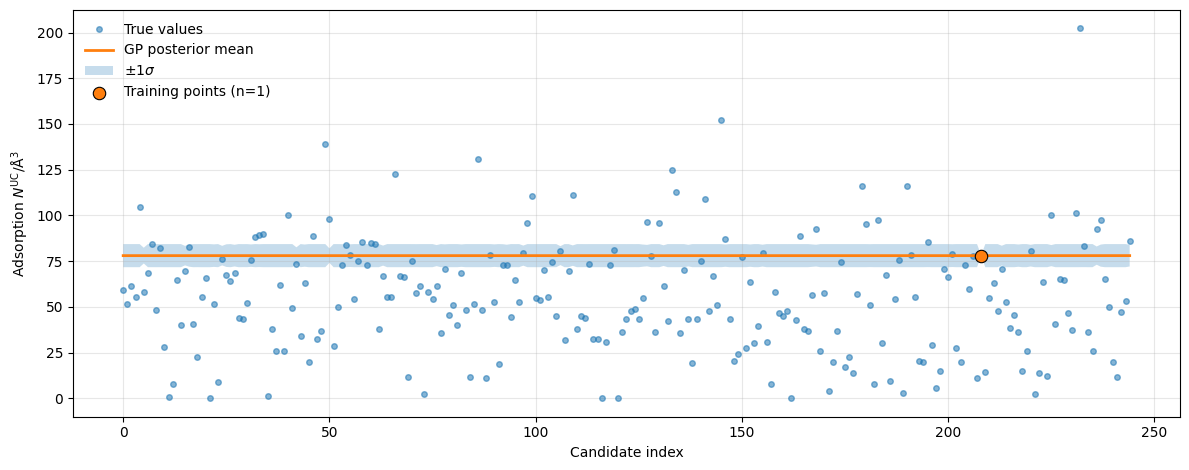

In [3]:
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import MinMaxScaler
from gpytorch.mlls import ExactMarginalLogLikelihood


# ============================================================
# CONFIG
# ============================================================
DFT_FILE  = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/dft_data_temp_pressure_swingswingswing.csv"
VEXT_FILE = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_hist_no_pressure_no_chem_20b_swing.csv"

TEMP = 298
PRESSURE = 1.0

LABEL = "beladung_pro_vol"

# if you want density_bulk in label definition:
USE_DENSITY_BULK = True

N_TRAIN = 1          # number of initial training points shown in plot
TRAIN_SEED = 0

GP_ITERS = 250
GP_LR = 0.2

SAVE = True
OUTFILE = "gp_visualization_candidates.png"


# ============================================================
# Helpers
# ============================================================
def is_bin_column(col) -> bool:
    if isinstance(col, (int, np.integer)):
        return True
    s = str(col)
    if s.isdigit():
        return True
    if re.fullmatch(r"bin_\d+", s):
        return True
    return False


# ============================================================
# GP model (matches your setup)
# ============================================================
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_gp(train_x: torch.Tensor, train_y: torch.Tensor, iters: int = 500, lr: float = 0.05):
    # --- force small noise so posterior goes through training points ---
    noise_constraint = gpytorch.constraints.Interval(1e-6, 1e-3)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)

    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # sensible initialisation
    model.covar_module.base_kernel.lengthscale = 0.2
    model.covar_module.outputscale = 1.0
    likelihood.noise = 1e-4

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    for _ in range(iters):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()
    return model, likelihood



# ============================================================
# Plot function (Pat-style, with true values)
# ============================================================
def plot_gp_over_candidates_with_truth(
    candidates_df: pd.DataFrame,
    y_true: np.ndarray,
    mean_scaled: torch.Tensor,
    var_scaled: torch.Tensor,
    label_scaler: MinMaxScaler,
    train_mask: np.ndarray,
    title: str,
    ylabel: str,
    save: bool = False,
    outfile: str = "gp_vis.png",
):
    # to numpy
    mean_s = mean_scaled.detach().cpu().numpy().flatten()
    var_s  = var_scaled.detach().cpu().numpy().flatten()
    std_s  = np.sqrt(np.maximum(var_s, 1e-12))

    y_true = np.asarray(y_true).flatten()

    # align lengths
    n = min(len(candidates_df), len(y_true), len(mean_s), len(std_s), len(train_mask))
    y_true = y_true[:n]
    mean_s = mean_s[:n]
    std_s  = std_s[:n]
    train_mask = train_mask[:n].astype(bool)

    # inverse transform mean
    mean = label_scaler.inverse_transform(mean_s.reshape(-1, 1)).reshape(-1)

    # inverse transform std (linearised for MinMaxScaler)
    # MinMaxScaler: y_scaled = (y - min) * scale_
    # inverse derivative: dy/dy_scaled = 1/scale_
    scale = float(label_scaler.scale_[0])  # = 1/(ymax-ymin)
    std = std_s / max(scale, 1e-12)

    x = np.arange(n)

    plt.figure(figsize=(12, 4.8))

    # true values
    plt.plot(x, y_true, linestyle="", marker="o", markersize=4, alpha=0.55, label="True values")

    # GP mean + uncertainty
    plt.plot(x, mean, linewidth=2.0, label="GP posterior mean")
    plt.fill_between(x, mean - std, mean + std, alpha=0.25, label=r"$\pm 1\sigma$")

    # highlight training points
    if train_mask.any():
        plt.scatter(
            x[train_mask], y_true[train_mask],
            s=80, marker="o", edgecolors="k", linewidths=0.8,
            label=f"Training points (n={train_mask.sum()})", zorder=5
        )

    #plt.title(title)
    plt.xlabel("Candidate index")
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()

    if save:
        plt.savefig(outfile, dpi=300, bbox_inches="tight")

    plt.show()


# ============================================================
# MAIN
# ============================================================
def main():
    # ---- load data ----
    dft_data = pd.read_csv(DFT_FILE)

    # clean density_bulk if needed
    if "density_bulk" in dft_data.columns:
        dft_data["density_bulk"] = (
            dft_data["density_bulk"]
            .astype(str).str.strip()
            .str.replace("[", "", regex=False)
            .str.replace("]", "", regex=False)
        )
        dft_data["density_bulk"] = pd.to_numeric(dft_data["density_bulk"], errors="coerce")

    expV_data = pd.read_csv(VEXT_FILE)

    data_all = pd.merge(dft_data, expV_data, "inner", on=["structure_name", "temperature_kelvin"])

    # filter state
    df_state = data_all[(data_all["temperature_kelvin"] == TEMP) & (data_all["pressure_bar"] == PRESSURE)].copy()
    if len(df_state) < max(10, N_TRAIN):
        raise ValueError(f"Too few samples in state: n={len(df_state)}")

    # feature columns
    feature_columns = [c for c in df_state.columns if is_bin_column(c)]
    if len(feature_columns) == 0:
        raise ValueError("No bin columns found. Check is_bin_column() vs your CSV columns.")

    df_state[LABEL] = (
            df_state["beladung_atoms"]
            .div(df_state["density_bulk"], axis=0)
            .div(df_state["volume_kubAng"], axis=0)
        )
    
    # normalize features like you do
    if "grid.dv" not in df_state.columns:
        raise ValueError("Column 'grid.dv' not found in merged data (needed for feature normalization).")

    df_state[feature_columns] = (
        df_state[feature_columns]
        .multiply(df_state["grid.dv"], axis=0)
        .div(df_state["volume_kubAng"], axis=0)
    )

    # drop NaNs
    df_state = df_state.dropna(subset=feature_columns + [LABEL]).copy()
    df_state = df_state.reset_index(drop=True)  # IMPORTANT: stable 0..N-1 indexing for plotting

    # "candidates" are all points (like a typical GP demo)
    candidates = df_state.copy()

    # choose training points (few!)
    rng = np.random.default_rng(TRAIN_SEED)
    train_pos = rng.choice(len(candidates), size=N_TRAIN, replace=False)
    train_mask = np.zeros(len(candidates), dtype=bool)
    train_mask[train_pos] = True

    # build X, y
    X = candidates[feature_columns].to_numpy(dtype=float)
    y_true = candidates[LABEL].to_numpy(dtype=float)

    # scale X globally
    x_scaler = MinMaxScaler().fit(X)
    Xs = x_scaler.transform(X)

    # scale y for GP training stability
    y_scaler = MinMaxScaler().fit(y_true.reshape(-1, 1))
    y_scaled = y_scaler.transform(y_true.reshape(-1, 1)).reshape(-1)

    # tensors
    X_train = torch.tensor(Xs[train_pos], dtype=torch.float32)
    y_train = torch.tensor(y_scaled[train_pos], dtype=torch.float32)

    X_test = torch.tensor(Xs, dtype=torch.float32)

    # train GP on few points
    model, likelihood = train_gp(X_train, y_train, iters=GP_ITERS, lr=GP_LR)

    # posterior over all candidates (same order!)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model(X_test)
        mean_scaled = pred.mean
        var_scaled = pred.variance

    title = rf"GP posterior on candidates (T={TEMP} K, p={PRESSURE:g} bar), trained on n={N_TRAIN}"
    ylabel = r"Adsorption $N^{\mathrm{UC}} / \mathrm{\AA}^{3}$" if LABEL == "beladung_pro_vol" else LABEL #/ (N/\mathrm{\AA}^{3})

    plot_gp_over_candidates_with_truth(
        candidates_df=candidates,
        y_true=y_true,
        mean_scaled=mean_scaled,
        var_scaled=var_scaled,
        label_scaler=y_scaler,
        train_mask=train_mask,
        title=title,
        ylabel=ylabel,
        save=SAVE,
        outfile=OUTFILE
    )


if __name__ == "__main__":
    main()


/Users/danielbock/MASTERTHESIS/MASTA/.venv/lib/python3.11/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


learned noise: 1.0031453712144867e-06
lengthscale: [0.20000002]
outputscale: 3.4435532143106684e-05


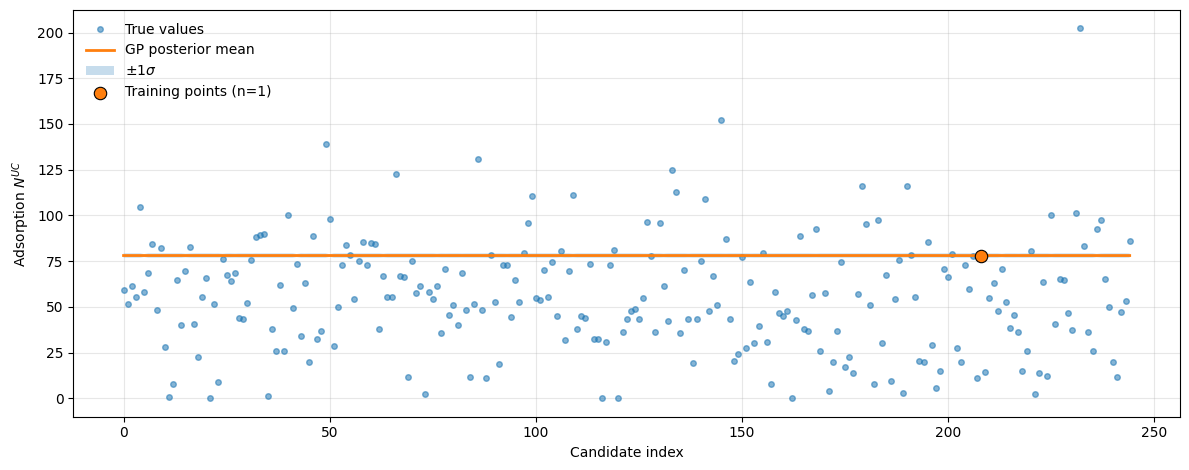

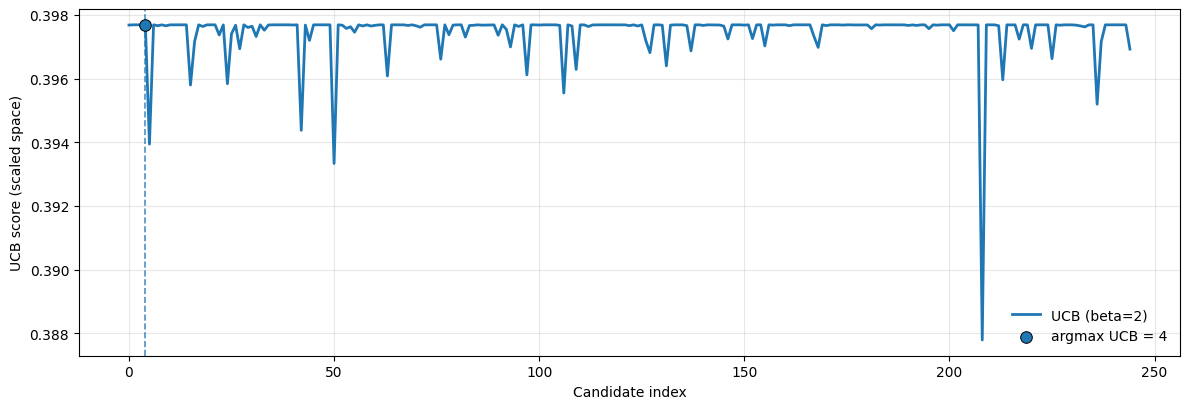

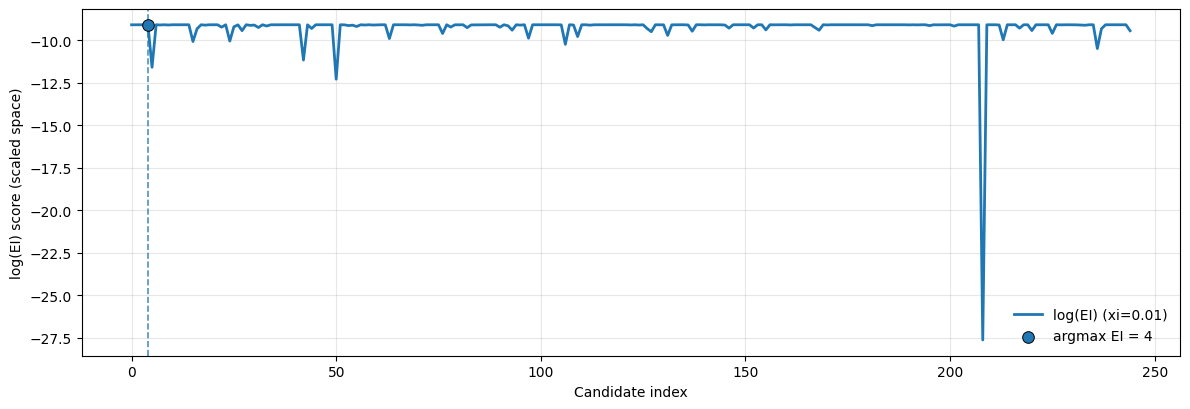

In [1]:
import numpy as np
import pandas as pd
import torch
import gpytorch
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import MinMaxScaler
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.distributions import Normal


# ============================================================
# CONFIG
# ============================================================
DFT_FILE  = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/dft_data_temp_pressure_swingswingswing.csv"
VEXT_FILE = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_hist_no_pressure_no_chem_20b_swing.csv"

TEMP = 298
PRESSURE = 1.0

LABEL = "beladung_pro_vol"
USE_DENSITY_BULK = True

N_TRAIN = 1
TRAIN_SEED = 0

GP_ITERS = 500
GP_LR = 0.05

# acquisition params (in scaled y-space!)
BETA = 2.0          # UCB
XI = 0.01           # EI

SAVE = True
OUTPREFIX = "gp_acq_vis"


# ============================================================
# Helpers
# ============================================================
def is_bin_column(col) -> bool:
    if isinstance(col, (int, np.integer)):
        return True
    s = str(col)
    if s.isdigit():
        return True
    if re.fullmatch(r"bin_\d+", s):
        return True
    return False


# ============================================================
# GP model
# ============================================================
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_gp(train_x: torch.Tensor, train_y: torch.Tensor, iters: int = 500, lr: float = 0.05):
    # force small noise -> interpolating behaviour
    noise_constraint = gpytorch.constraints.Interval(1e-6, 1e-3)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=noise_constraint)

    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # init (helps avoid "flat posterior")
    model.covar_module.base_kernel.lengthscale = 0.2
    model.covar_module.outputscale = 1.0
    likelihood.noise = 1e-4

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    for _ in range(iters):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()
    return model, likelihood


# ============================================================
# Acquisition functions (operate in SCALED y-space)
# ============================================================
def ucb(mean_s: torch.Tensor, var_s: torch.Tensor, beta: float = 2.0):
    return mean_s + beta * torch.sqrt(torch.clamp(var_s, min=1e-12))


def expected_improvement(mean_s: torch.Tensor, var_s: torch.Tensor, best_f_s: float, xi: float = 0.0):
    std_s = torch.sqrt(torch.clamp(var_s, min=1e-12))
    z = (mean_s - best_f_s - xi) / torch.clamp(std_s, min=1e-12)

    normal = Normal(torch.zeros_like(z), torch.ones_like(z))
    cdf = normal.cdf(z)
    pdf = torch.exp(normal.log_prob(z))

    ei = std_s * (z * cdf + pdf)
    return torch.clamp(ei, min=0.0)


# ============================================================
# Plotting (Pat-style)
# ============================================================
def inv_minmax_std(std_scaled: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    # MinMaxScaler: y_scaled = (y - min) * scale_
    # inverse derivative dy/dy_scaled = 1/scale_
    scale = float(scaler.scale_[0])  # 1/(ymax-ymin)
    return std_scaled / max(scale, 1e-12)


def plot_posterior_and_acq(
    y_true: np.ndarray,
    mean_s: torch.Tensor,
    var_s: torch.Tensor,
    y_scaler: MinMaxScaler,
    train_mask: np.ndarray,
    title: str,
    ylabel: str,
    beta: float,
    xi: float,
    save: bool = False,
    outprefix: str = "gp_acq_vis",
):
    mean_s_np = mean_s.detach().cpu().numpy().flatten()
    var_s_np  = var_s.detach().cpu().numpy().flatten()
    std_s_np  = np.sqrt(np.maximum(var_s_np, 1e-12))

    n = min(len(y_true), len(mean_s_np), len(std_s_np), len(train_mask))
    y_true = np.asarray(y_true).flatten()[:n]
    mean_s_np = mean_s_np[:n]
    std_s_np  = std_s_np[:n]
    train_mask = np.asarray(train_mask).astype(bool)[:n]

    # unscale mean/std to original units
    mean = y_scaler.inverse_transform(mean_s_np.reshape(-1, 1)).reshape(-1)
    std  = inv_minmax_std(std_s_np, y_scaler)

    x = np.arange(n)

    # acquisition in scaled space
    mean_s_t = torch.tensor(mean_s_np, dtype=torch.float32)
    var_s_t  = torch.tensor((std_s_np ** 2), dtype=torch.float32)
    score_ucb = ucb(mean_s_t, var_s_t, beta=beta).detach().cpu().numpy()

    # best_f in scaled space from TRAINING points (important!)
    best_f_s = float(mean_s_np[train_mask].max()) if train_mask.any() else float(mean_s_np.max())
    score_ei = expected_improvement(mean_s_t, var_s_t, best_f_s=best_f_s, xi=xi).detach().cpu().numpy()
    score_ei_log = np.log(np.maximum(score_ei, 1e-12))

    # argmax picks
    pick_ucb = int(np.argmax(score_ucb))
    pick_ei  = int(np.argmax(score_ei))

    # -------------------------
    # FIGURE 1: Posterior
    # -------------------------
    plt.figure(figsize=(12, 4.8))
    plt.plot(x, y_true, linestyle="", marker="o", markersize=4, alpha=0.55, label="True values")
    plt.plot(x, mean, linewidth=2.0, label="GP posterior mean")
    plt.fill_between(x, mean - std, mean + std, alpha=0.25, label=r"$\pm 1\sigma$")

    if train_mask.any():
        plt.scatter(x[train_mask], y_true[train_mask], s=80, edgecolors="k", linewidths=0.8,
                    label=f"Training points (n={train_mask.sum()})", zorder=5)

    #plt.title(title)
    plt.xlabel("Candidate index")
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    if save:
        plt.savefig(f"{outprefix}_posterior.png", dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------
    # FIGURE 2: UCB and EI (separate for clean scales)
    # -------------------------
    plt.figure(figsize=(12, 4.2))
    plt.plot(x, score_ucb, linewidth=2.0, label=rf"UCB (beta={beta:g})")
    plt.axvline(pick_ucb, linestyle="--", linewidth=1.2, alpha=0.8)
    plt.scatter([pick_ucb], [score_ucb[pick_ucb]], s=70, edgecolors="k", linewidths=0.7, zorder=5,
                label=f"argmax UCB = {pick_ucb}")
    #plt.title("Acquisition function: UCB")
    plt.xlabel("Candidate index")
    plt.ylabel("UCB score (scaled space)")
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    if save:
        plt.savefig(f"{outprefix}_ucb.png", dpi=300, bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(12, 4.2))
    plt.plot(x, score_ei_log, linewidth=2.0, label=rf"log(EI) (xi={xi:g})")
    plt.axvline(pick_ei, linestyle="--", linewidth=1.2, alpha=0.8)
    plt.scatter([pick_ei], [score_ei_log[pick_ei]], s=70, edgecolors="k", linewidths=0.7, zorder=5,
                label=f"argmax EI = {pick_ei}")
    #plt.title("Acquisition function: Expected Improvement (log scale)")
    plt.xlabel("Candidate index")
    plt.ylabel("log(EI) score (scaled space)")
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    if save:
        plt.savefig(f"{outprefix}_ei.png", dpi=300, bbox_inches="tight")
    plt.show()


# ============================================================
# MAIN
# ============================================================
def main():
    dft_data = pd.read_csv(DFT_FILE)

    if "density_bulk" in dft_data.columns:
        dft_data["density_bulk"] = (
            dft_data["density_bulk"]
            .astype(str).str.strip()
            .str.replace("[", "", regex=False)
            .str.replace("]", "", regex=False)
        )
        dft_data["density_bulk"] = pd.to_numeric(dft_data["density_bulk"], errors="coerce")

    expV_data = pd.read_csv(VEXT_FILE)
    data_all = pd.merge(dft_data, expV_data, "inner", on=["structure_name", "temperature_kelvin"])

    df_state = data_all[(data_all["temperature_kelvin"] == TEMP) & (data_all["pressure_bar"] == PRESSURE)].copy()
    if len(df_state) < max(10, N_TRAIN):
        raise ValueError(f"Too few samples in state: n={len(df_state)}")

    feature_columns = [c for c in df_state.columns if is_bin_column(c)]
    if len(feature_columns) == 0:
        raise ValueError("No bin columns found. Check is_bin_column() vs your CSV columns.")

    # label
    if USE_DENSITY_BULK:
        if "density_bulk" not in df_state.columns:
            raise ValueError("USE_DENSITY_BULK=True but 'density_bulk' column not found.")
        df_state[LABEL] = (
            df_state["beladung_atoms"]
            .div(df_state["density_bulk"], axis=0)
            .div(df_state["volume_kubAng"], axis=0)
        )
    else:
        df_state[LABEL] = df_state["beladung_atoms"].div(df_state["volume_kubAng"], axis=0)

    # features
    if "grid.dv" not in df_state.columns:
        raise ValueError("Column 'grid.dv' not found (needed for feature normalization).")

    df_state[feature_columns] = (
        df_state[feature_columns]
        .multiply(df_state["grid.dv"], axis=0)
        .div(df_state["volume_kubAng"], axis=0)
    )

    df_state = df_state.dropna(subset=feature_columns + [LABEL]).reset_index(drop=True)

    # candidates: ALL points, in current df order (this defines "candidate index")
    candidates = df_state.copy()

    X = candidates[feature_columns].to_numpy(dtype=float)
    y_true = candidates[LABEL].to_numpy(dtype=float)

    # scale X
    x_scaler = MinMaxScaler().fit(X)
    Xs = x_scaler.transform(X)

    # scale y
    y_scaler = MinMaxScaler().fit(y_true.reshape(-1, 1))
    y_scaled = y_scaler.transform(y_true.reshape(-1, 1)).reshape(-1)

    # choose training points
    rng = np.random.default_rng(TRAIN_SEED)
    train_pos = rng.choice(len(candidates), size=N_TRAIN, replace=False)
    train_mask = np.zeros(len(candidates), dtype=bool)
    train_mask[train_pos] = True

    X_train = torch.tensor(Xs[train_pos], dtype=torch.float32)
    y_train = torch.tensor(y_scaled[train_pos], dtype=torch.float32)

    X_test = torch.tensor(Xs, dtype=torch.float32)

    # train GP
    model, likelihood = train_gp(X_train, y_train, iters=GP_ITERS, lr=GP_LR)

    # posterior
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = model(X_test)
        mean_s = pred.mean
        var_s  = pred.variance

    # debug (optional but useful)
    print("learned noise:", float(likelihood.noise.item()))
    print("lengthscale:", model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().ravel()[:5])
    print("outputscale:", float(model.covar_module.outputscale.item()))

    title = rf"GP posterior + acquisitions (T={TEMP} K, p={PRESSURE:g} bar), trained on n={N_TRAIN}"
    ylabel = r"Adsorption $N^{UC}$" if LABEL == "beladung_pro_vol" else LABEL

    plot_posterior_and_acq(
        y_true=y_true,
        mean_s=mean_s,
        var_s=var_s,
        y_scaler=y_scaler,
        train_mask=train_mask,
        title=title,
        ylabel=ylabel,
        beta=BETA,
        xi=XI,
        save=SAVE,
        outprefix=OUTPREFIX,
    )


if __name__ == "__main__":
    main()
